# Load

In [1]:
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_json('json/corpus.json')
df = df.reset_index().drop(columns = ['index'])

In [3]:
df.head(1)

track_id   title_billboard artist_billboard  \
0  5ayybTSXNwcarDtxQKqvWX  Poor Little Fool     Ricky Nelson   

                   title_spotify artist_spotify  root  time_signature  mode  \
0  Poor Little Fool - Remastered   Ricky Nelson   0.0             4.0   1.0   

     tempo  loudness  duration_ms  energy  valence  \
0  154.999   -11.573     153933.0   0.332    0.795   

                                          genre_list    weeks_list ranks_list  \
0  [adult standards, brill building pop, bubblegu...  [1958-08-08]        [1]   

  highest_rank  #weeks  year  
0            1     1.0     0

In [4]:
df = df[df['weeks_list'] != None]

In [5]:
len(df)

19098

In [6]:
list_ = []

for ind, item in df['weeks_list'].iteritems():
    if item != None:
        list_.append(ind)

In [7]:
df = df.iloc[list_]

In [8]:
features = pd.read_json('json/weekly_features.json')
monthly_features = pd.read_json('json/monthly_features.json')
yearly_features = pd.read_json('json/yearly_features.json')

# Functions

In [9]:
def mean_confidence_interval(data, confidence = 0.95):
    
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [10]:
def compute_bounds(features, feature):
    
    lower_bound, mean, upper_bound = [], [], []

    # Compute the 95% confidence interval
    for week in range(len(features[feature])):
        m, lb, ub = mean_confidence_interval(features[feature][week])
    
        lower_bound.append(lb)
        mean.append(m)
        upper_bound.append(ub)
        
    return lower_bound, mean, upper_bound

In [11]:
def plot_feature_evolution(features, feature, color = 'b', N = 48, granularity = 'Weeks', unit = ''):
    
    sns.set(rc={'figure.figsize':(30,10)})
    sns.set_style("ticks")
    sns.set_context('notebook', font_scale=2.5)
    
    years = np.arange(1959, 1997)
    lower_bound, mean, upper_bound = compute_bounds(features, feature)
    plt.fill_between(range(len(mean)), upper_bound, lower_bound, color = color, alpha = .3)
    plt.plot(mean, color)
    
    name = feature.replace('_', ' ').capitalize()
    plt.xticks(np.arange(0, (len(years))*N, N), years, rotation = 'vertical')
    plt.xlabel('\n' + granularity)
    plt.ylabel(name + ' ' + unit)
    plt.title(name + ' change by ' + granularity.lower()[:-1] + '\n')

    return plt

In [12]:
def plot_discrete_feature_evolution(features, feature, granularity = 'Weeks', categories = '',
                                    reorder = None):
    
    sns.set(rc={'figure.figsize':(30,10)})
    sns.set_style("ticks")
    sns.set_context('notebook', font_scale=2.5)
    
    years = np.arange(1959, 1996)
    
    all_entries = []
    for i in range(len(features[feature])):
        list_ = features[feature][i]
        for element in list_:
            all_entries.append(element)
        
    dico = {}
    keys = sorted(pd.Series(all_entries).value_counts().keys().tolist())
    for key in keys:
        dico[key] = []

    for timespan in range(len(features)):
        entries = features[feature][timespan]
        serie = pd.Series(entries).value_counts()
        count = np.sum(serie.values)
        for key in keys:
            try:
                dico[key].append(serie[key]/count)
            except:
                dico[key].append(0.)

    name = feature.replace('_', ' ').capitalize()
    xlabel = '\n' + granularity
    ylabel = name + ' (relative share)'
    title = name + ' change by ' + granularity.lower()[:-1] + '\n'
    
    df_dico = pd.DataFrame(dico, index = years)
    
    if categories != '':
        for i in range(len(df_dico.columns)):
            df_dico = df_dico.rename(columns = {df_dico.columns[i]: categories[i]})
    
    if reorder != None:
        df_dico = df_dico[reorder]
    
    ax = df_dico.plot.area(legend = 'reverse', title = title)    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    return ax

In [13]:
def salient_drift(features, feature, means, N = 48, granularity = 'Weeks'):
    
    color = '#989898'
    lower_bound, mean, upper_bound = compute_bounds(features, feature)
    salient_low, salient_high = [], []
    ampl_low, ampl_high = [], []
    
    for i in range(len(lower_bound)):
        if lower_bound[i] > means[feature]:
            salient_high.append(i)
            ampl_high.append(mean[i])
            
        if upper_bound[i] < means[feature]:
            salient_low.append(i)
            ampl_low.append(mean[i])

    sns.set(rc={'figure.figsize':(30,10)})
    sns.set_style("ticks")
    sns.set_context('notebook', font_scale=2.5)
    
    years = np.arange(1959, 1997)
    #plt.fill_between(range(len(mean)), upper_bound, lower_bound, color = color, alpha = .3)
    plt.plot(mean, color)
    plt.plot(salient_low, ampl_low, color='#01B9FF', marker='o', linestyle = '')
    plt.plot(salient_high, ampl_high, color='#FF0101', marker='o', linestyle = '')
    
    name = feature.replace('_', ' ').capitalize()
    plt.xticks(np.arange(0, (len(years))*N, N), years, rotation = 'vertical')
    plt.xlabel(granularity)
    plt.ylabel(name)
    plt.title(name + ' salient drifts at ' + granularity.lower()[:-1] + ' granularity \n')

    return plt, salient_low, salient_high

# Weeks

In [14]:
all_weeks = []

for ind, item in df['weeks_list'].iteritems():
    for week in item:
        all_weeks.append(week)
        
weeks = pd.Series(all_weeks).value_counts().index

In [15]:
weeks = sorted(weeks)[1:]

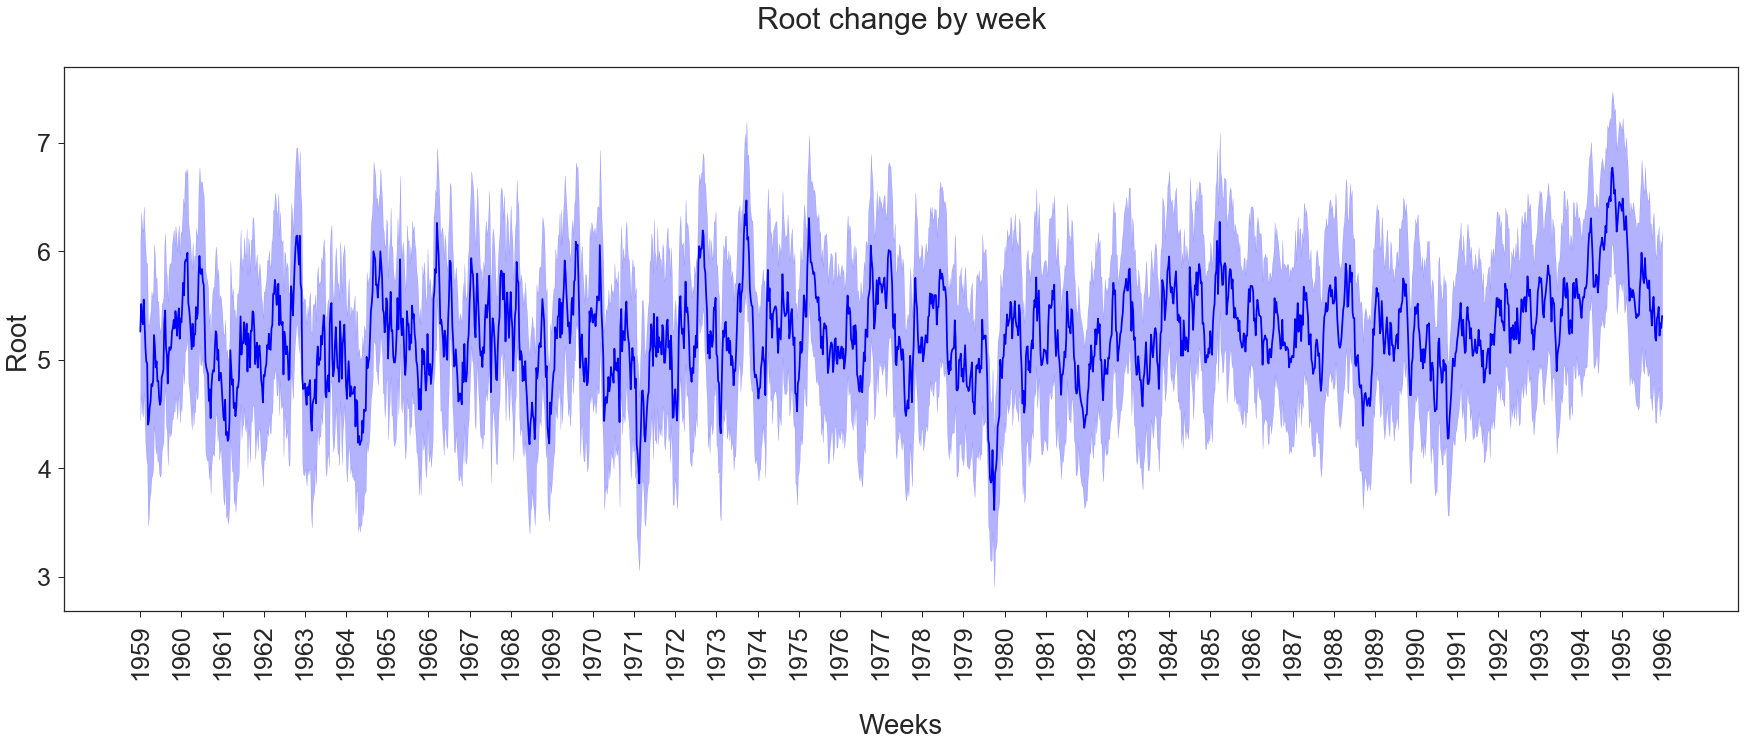

In [16]:
plot_feature_evolution(features, 'root');

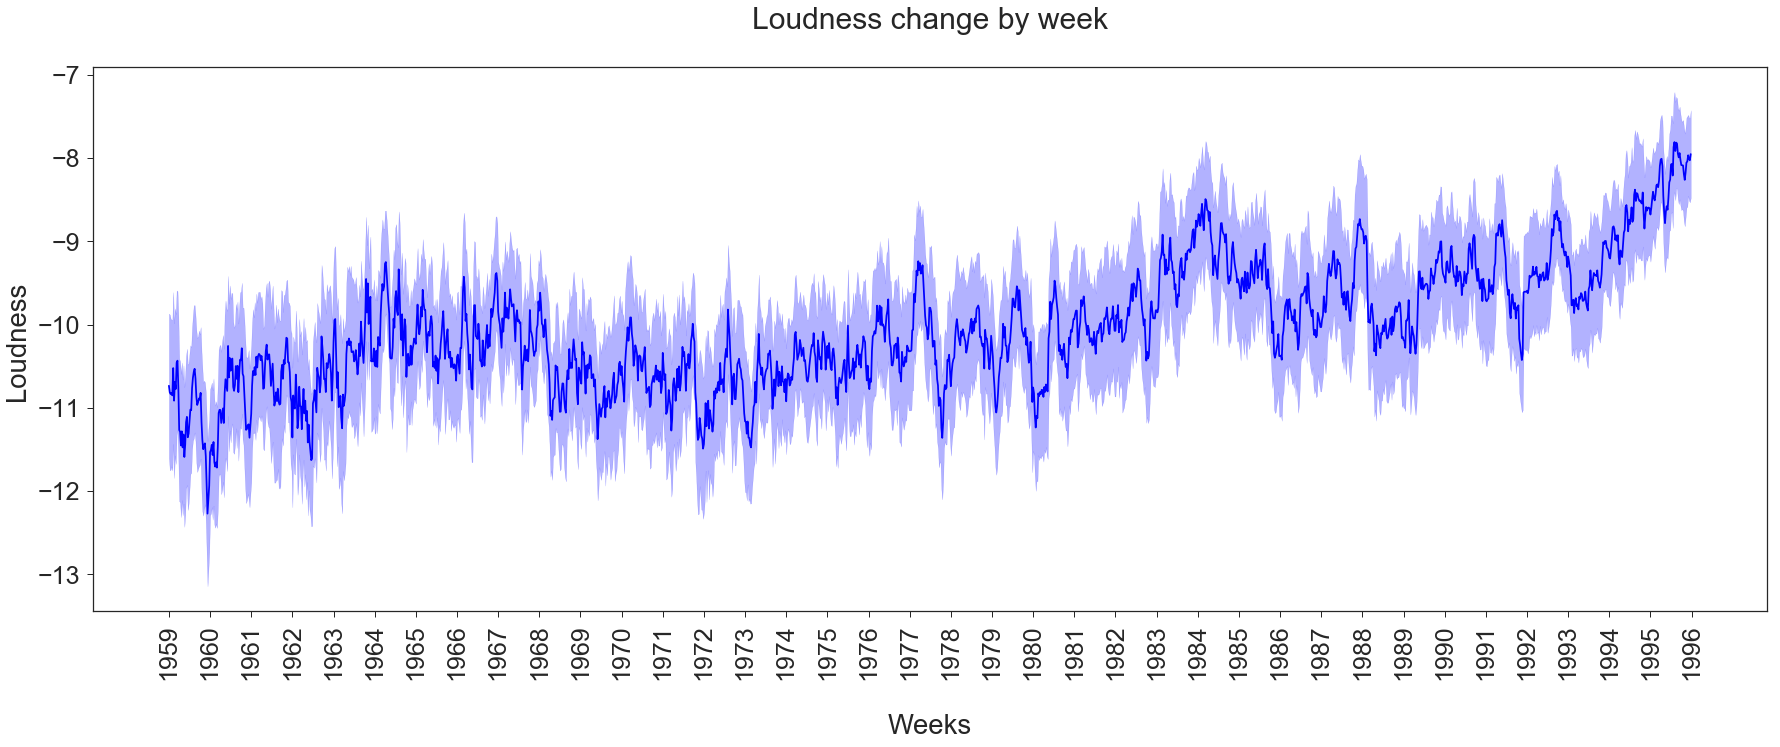

In [17]:
plot_feature_evolution(features, 'loudness');

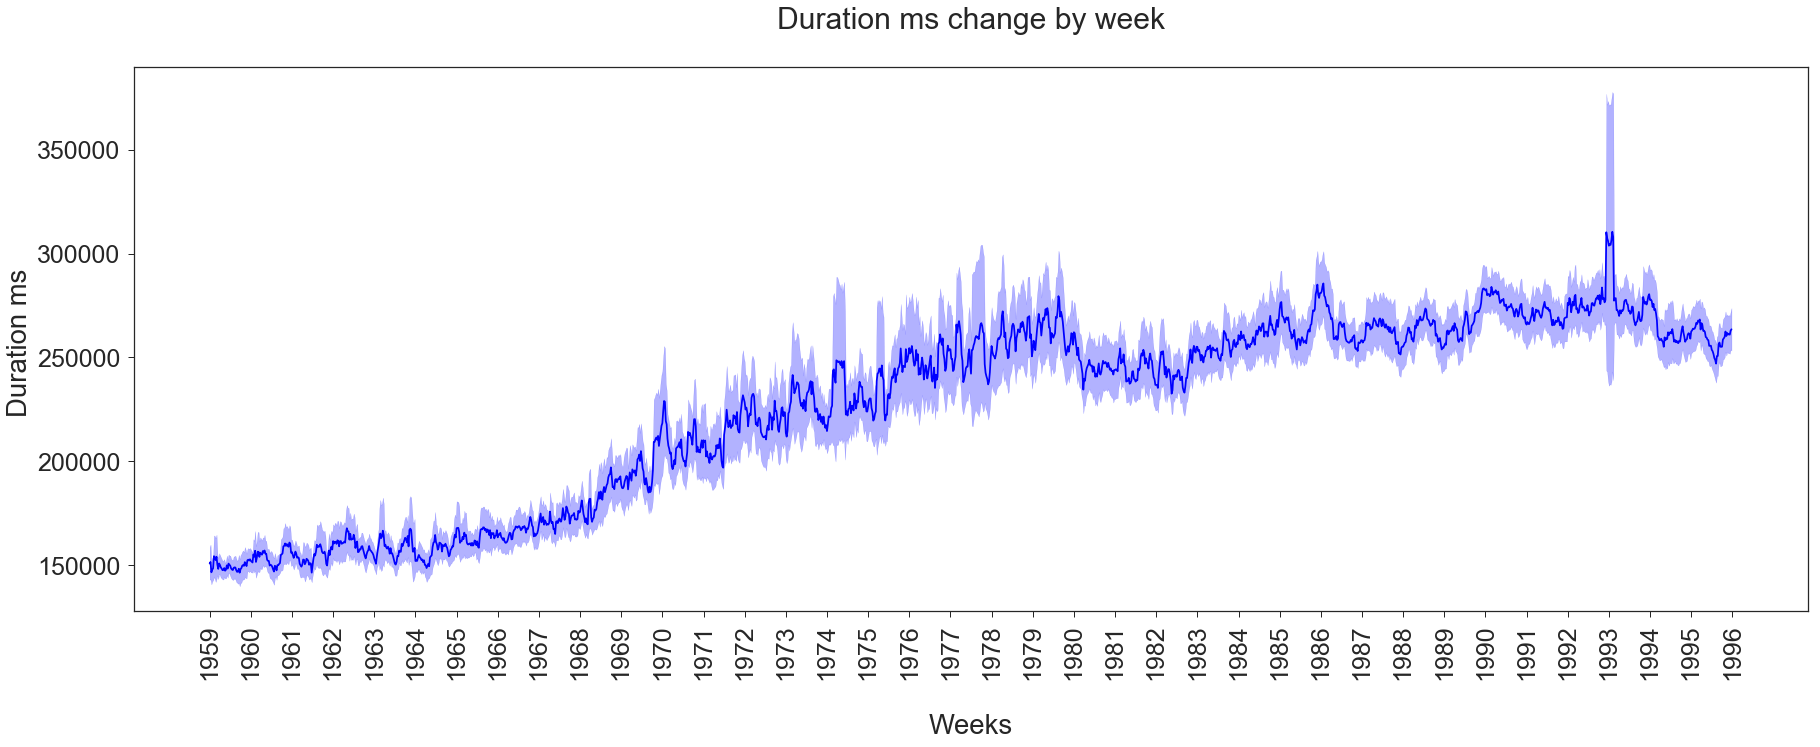

In [18]:
plot_feature_evolution(features, 'duration_ms');

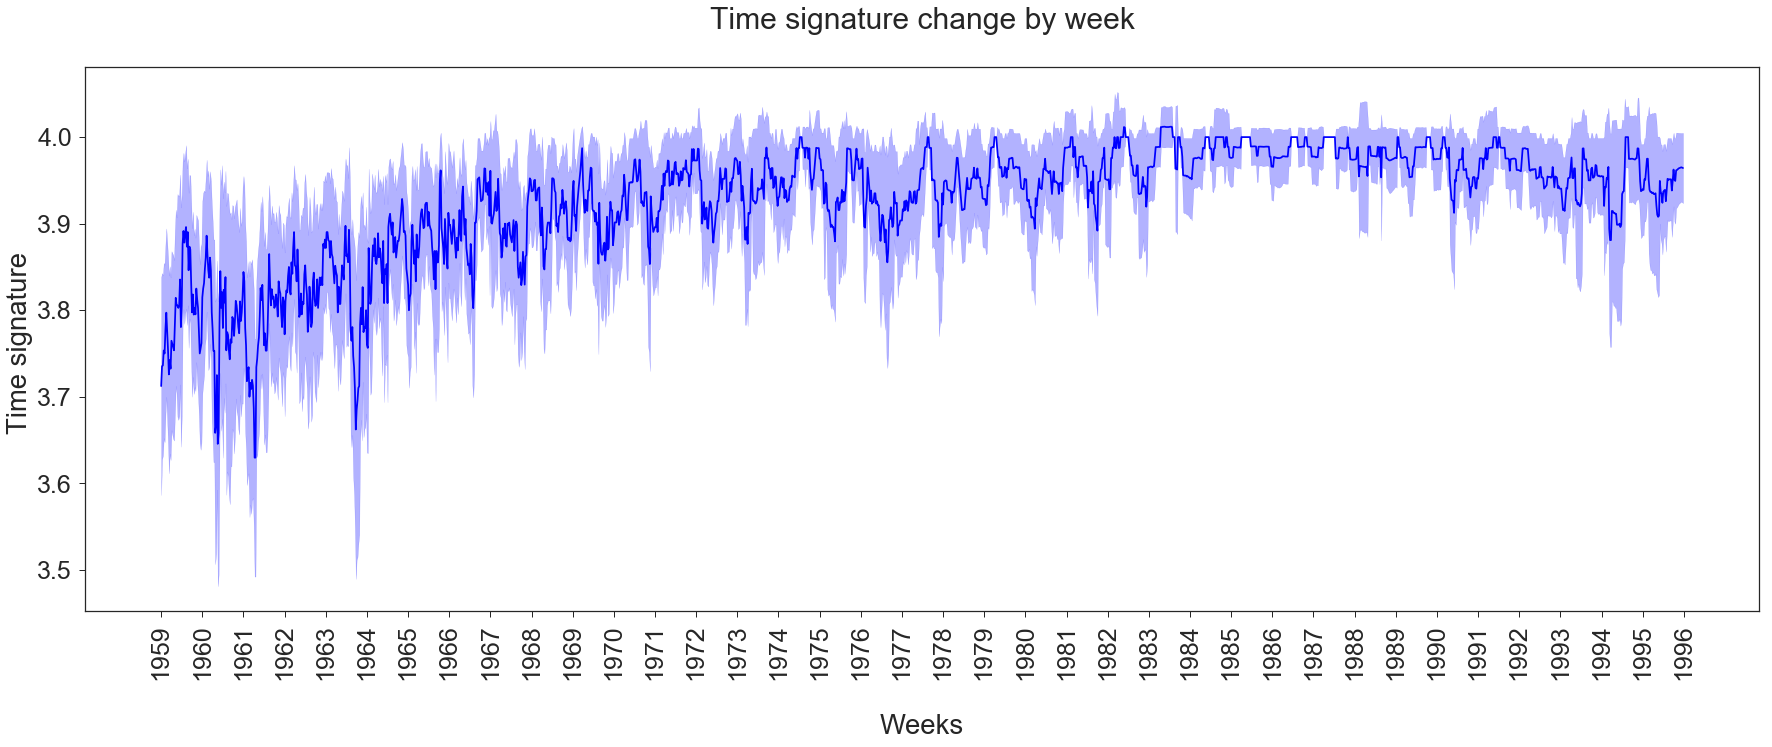

In [19]:
plot_feature_evolution(features, 'time_signature');

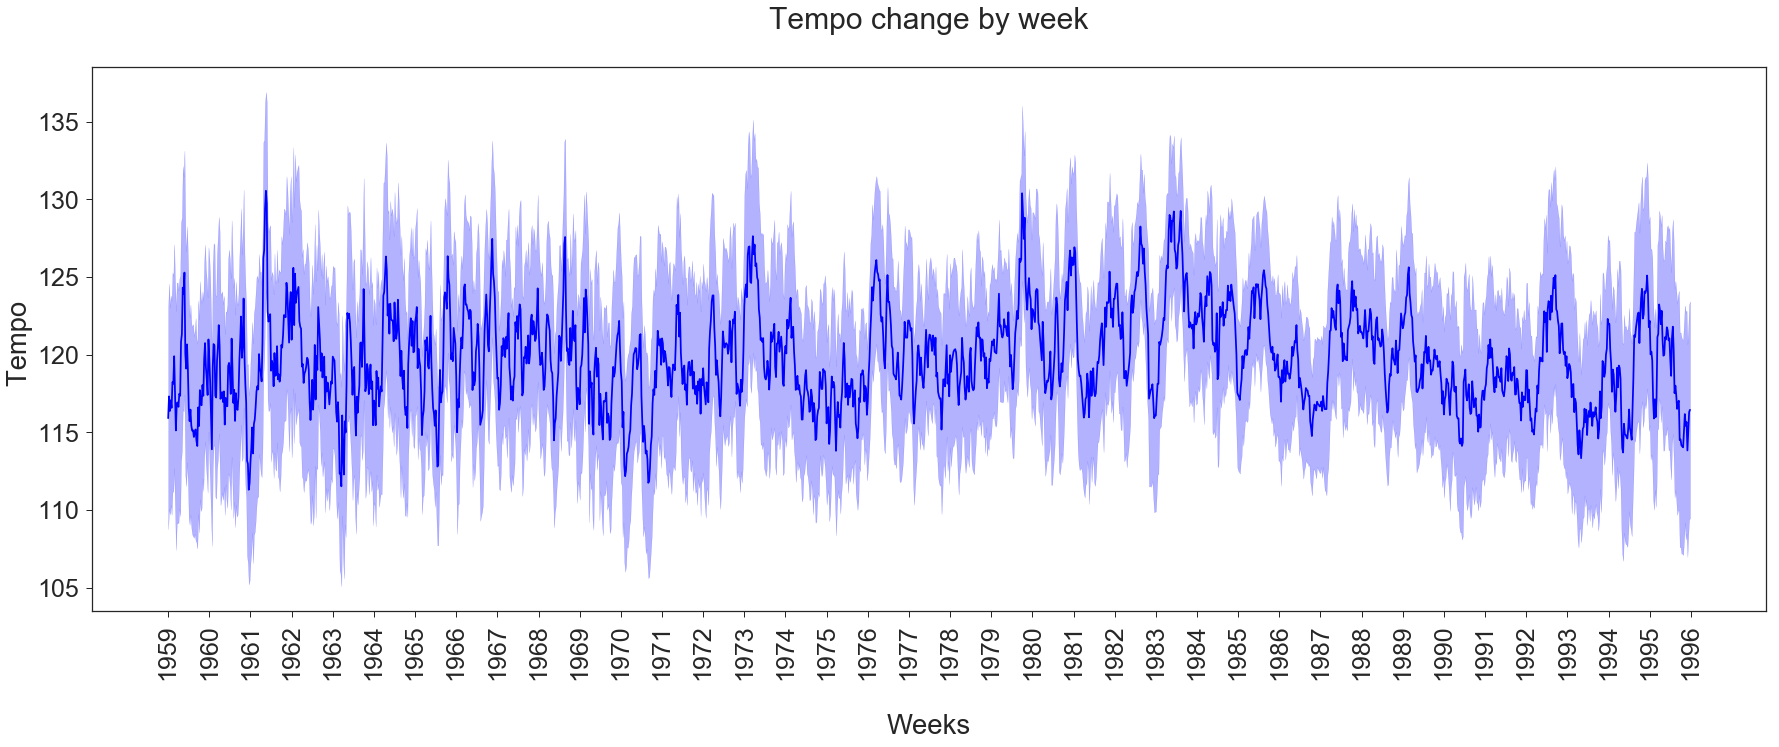

In [20]:
plot_feature_evolution(features, 'tempo');

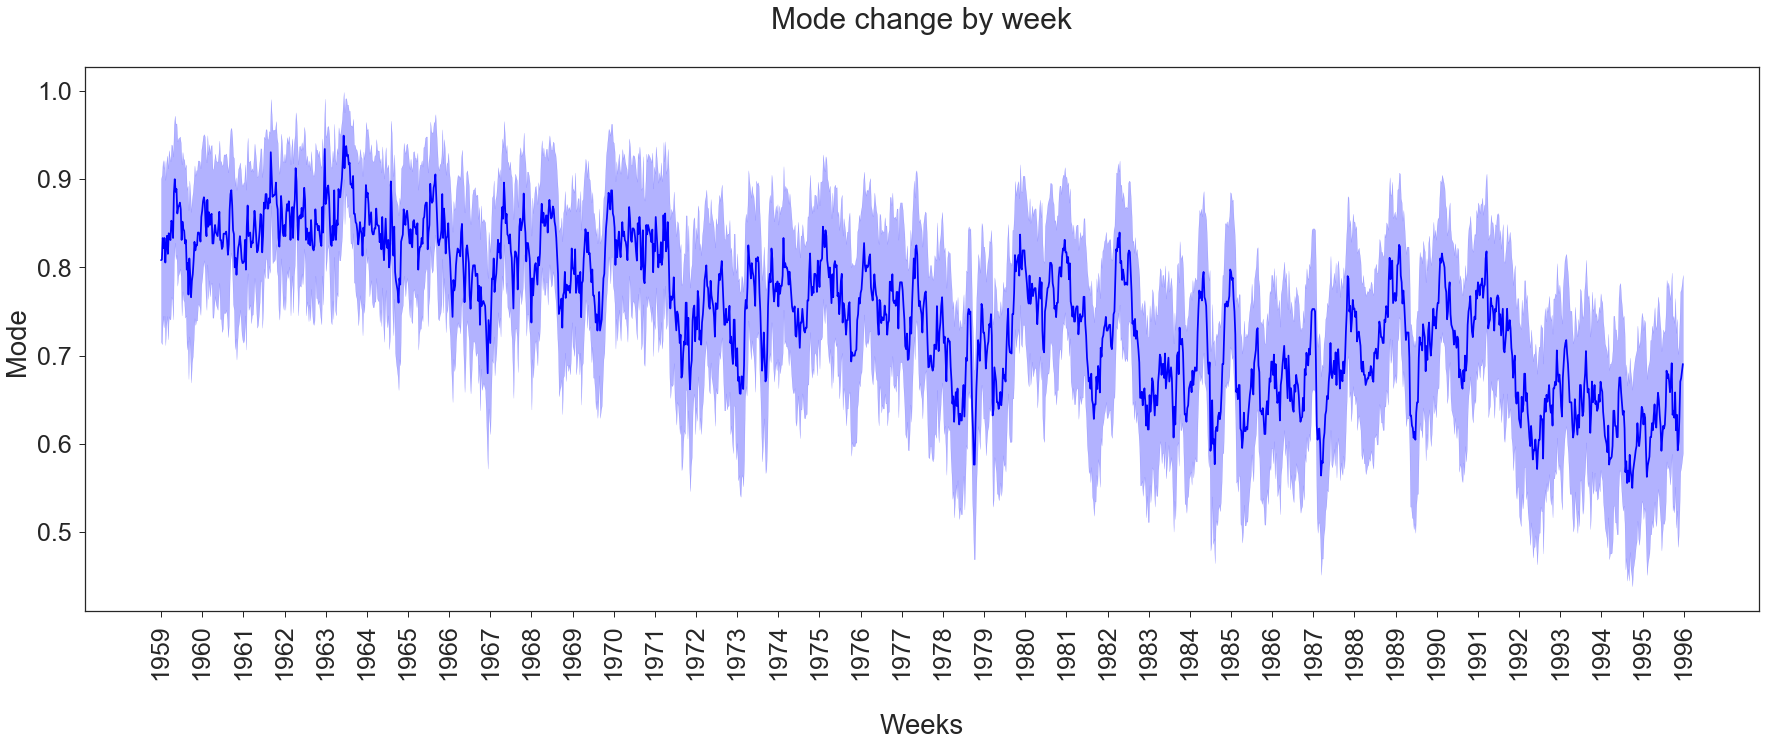

In [21]:
plot_feature_evolution(features, 'mode');

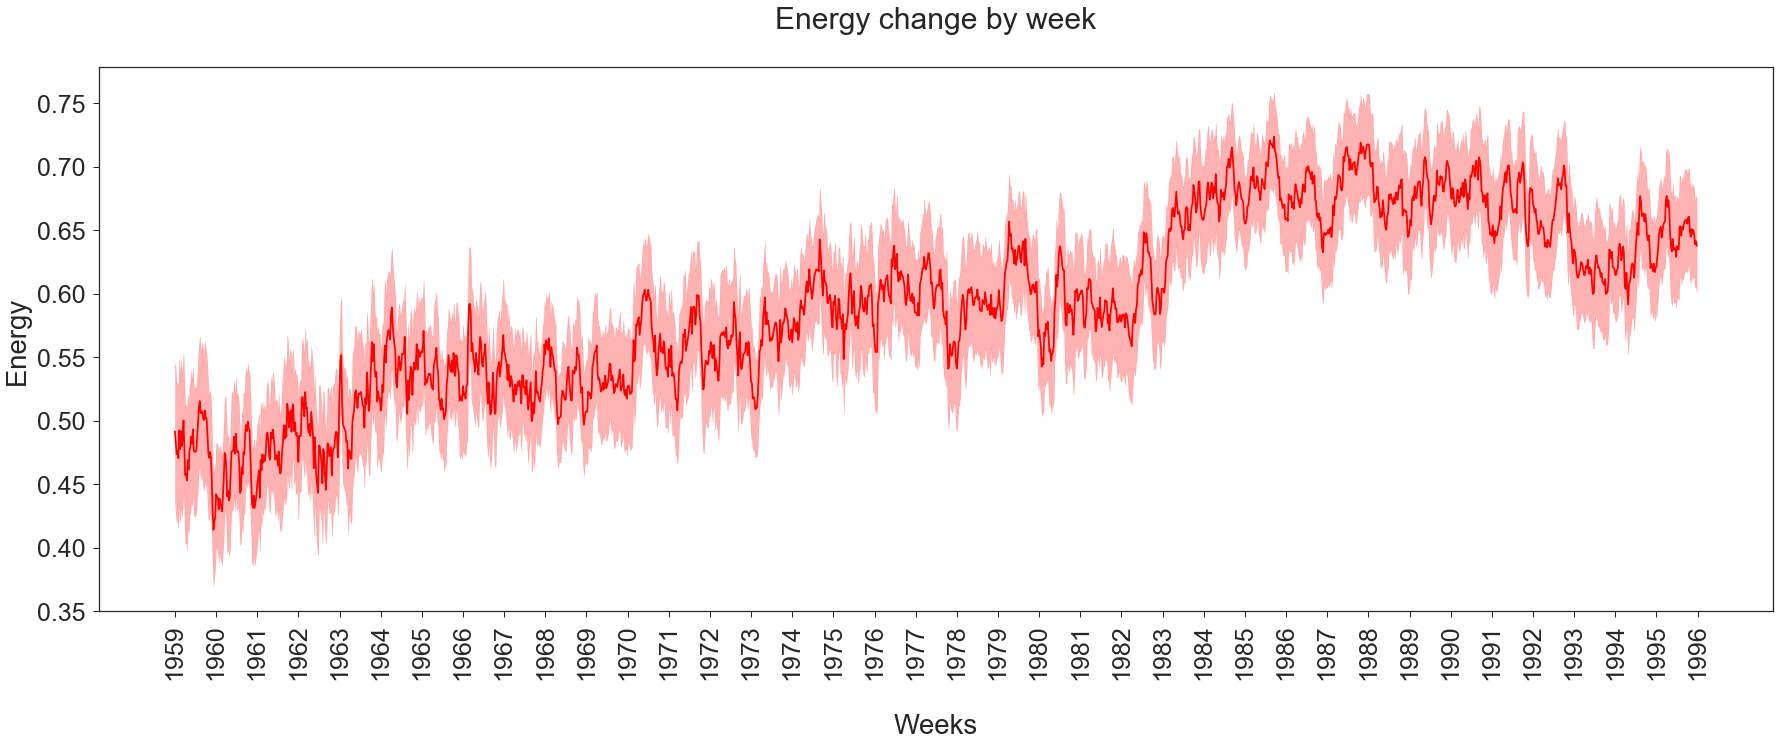

In [22]:
plot_feature_evolution(features, 'energy', color = 'r');

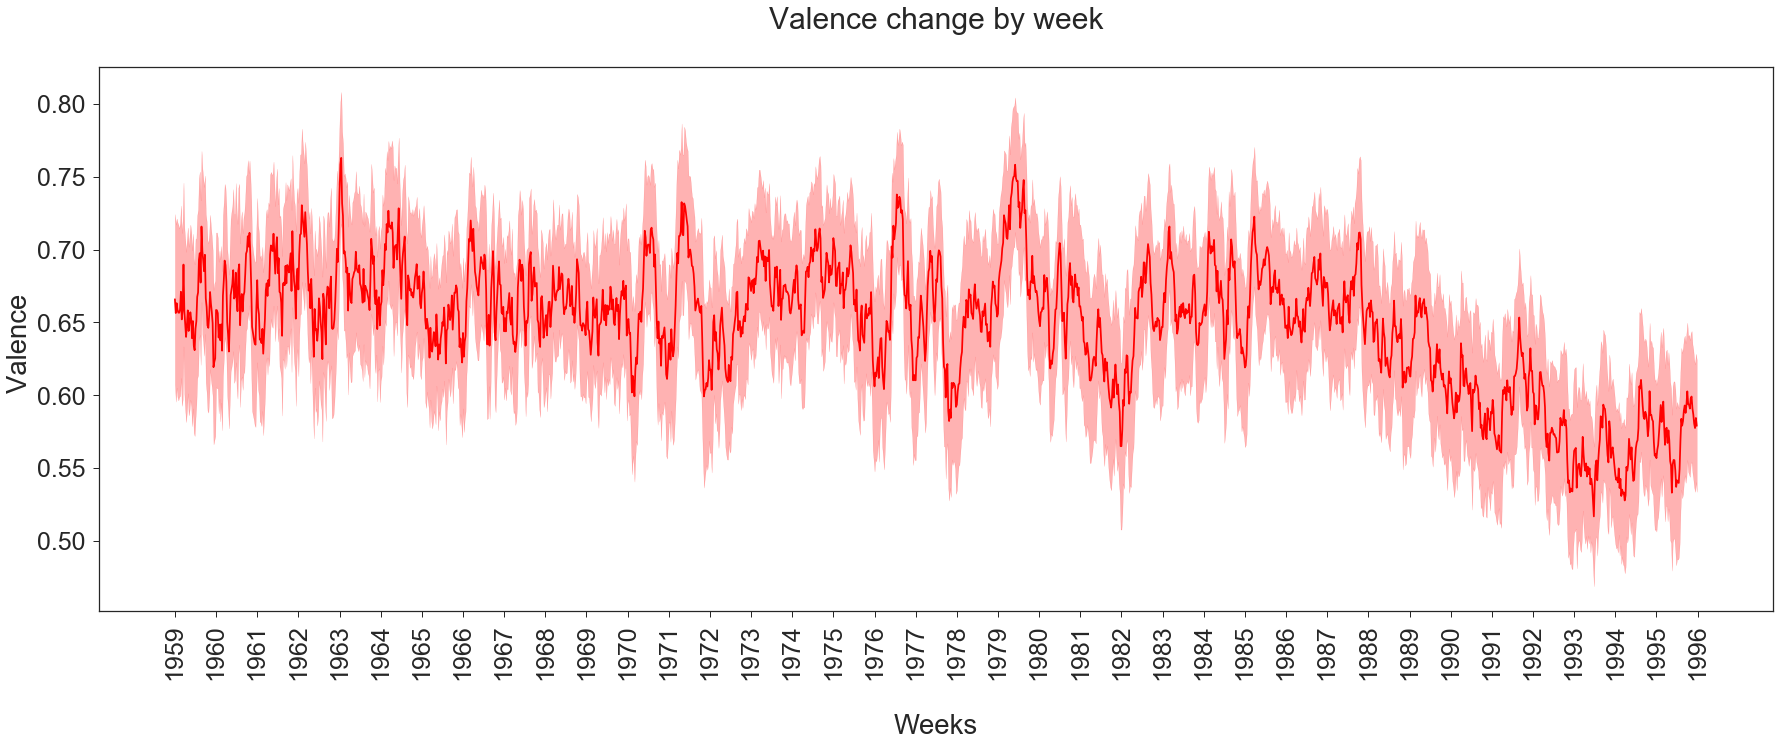

In [23]:
plot_feature_evolution(features, 'valence', color = 'r');

In [24]:
trend = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

for key in trend.keys():
    for i in range(len(weeks)):
        trend[key].append(np.mean(features[key][i]))

In [25]:
df_trend = pd.DataFrame(trend)

In [26]:
sns.set(rc={'figure.figsize':(10,7)})
sns.set_style("ticks")
sns.set_context('notebook', font_scale=1)

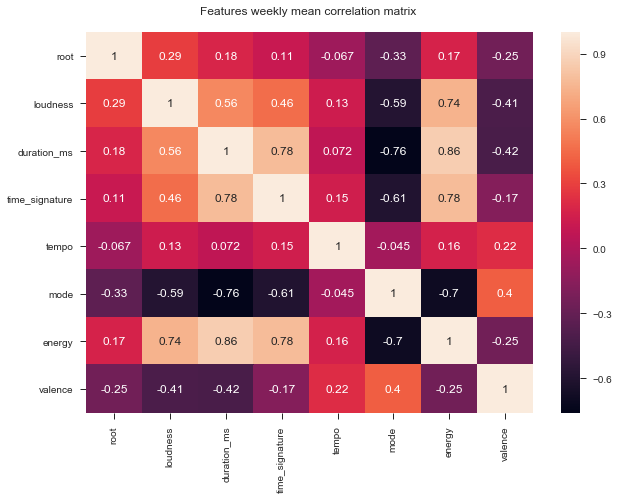

In [27]:
sns.heatmap(df_trend.corr(), annot=True).set_title('Features weekly mean correlation matrix \n');

## Horizontal salience

In [28]:
sns.set(rc={'figure.figsize':(10,7)})
sns.set_style("ticks")
sns.set_context('notebook', font_scale=2.5)

In [29]:
means = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

for key in trend.keys():
    means[key] = np.mean(trend[key])

In [30]:
salient_low_list = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}
salient_high_list = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

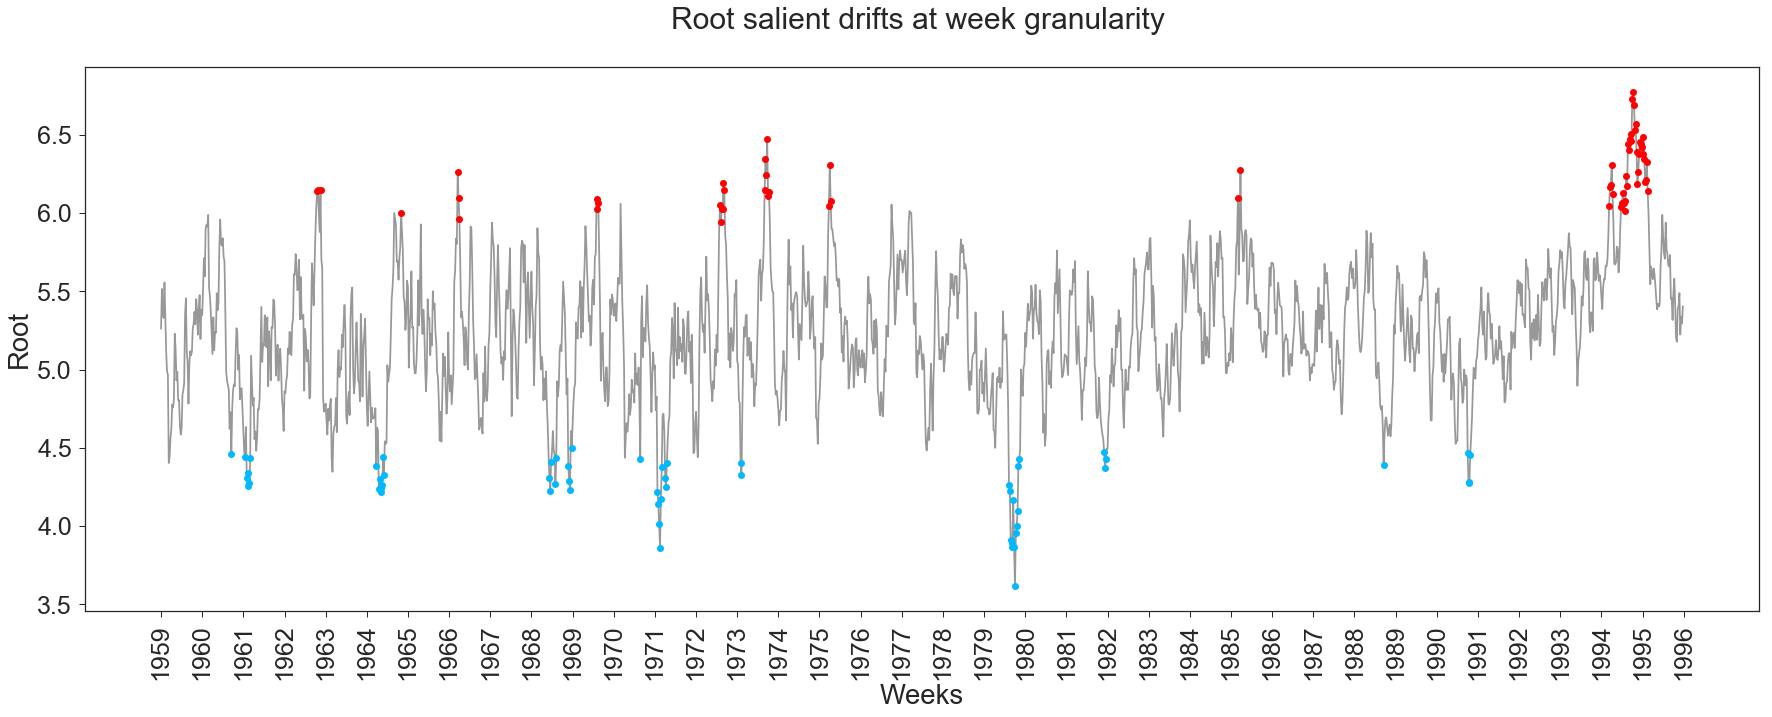

In [31]:
feature = 'root'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

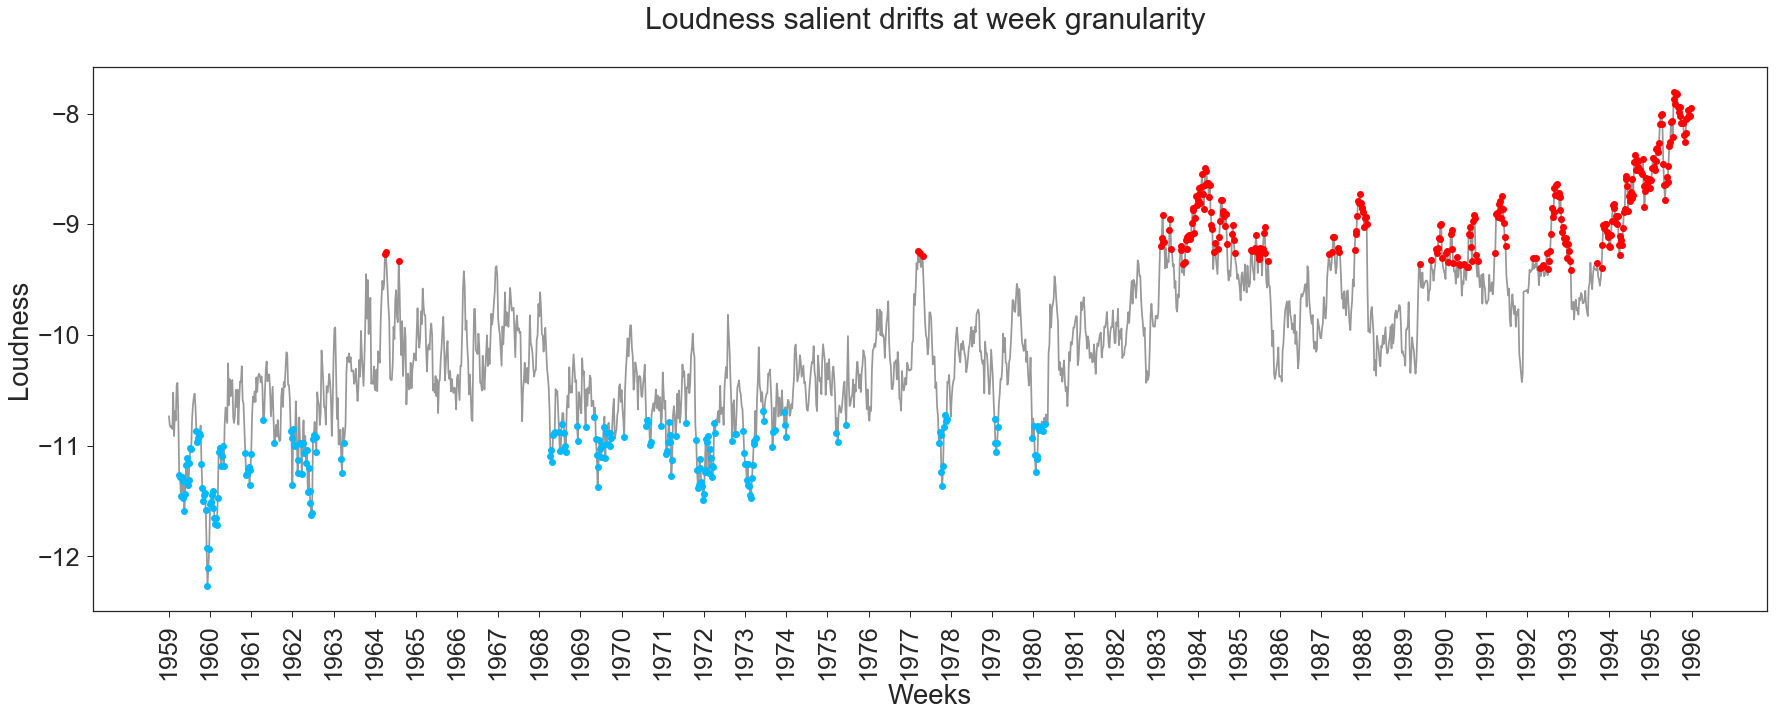

In [32]:
feature = 'loudness'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

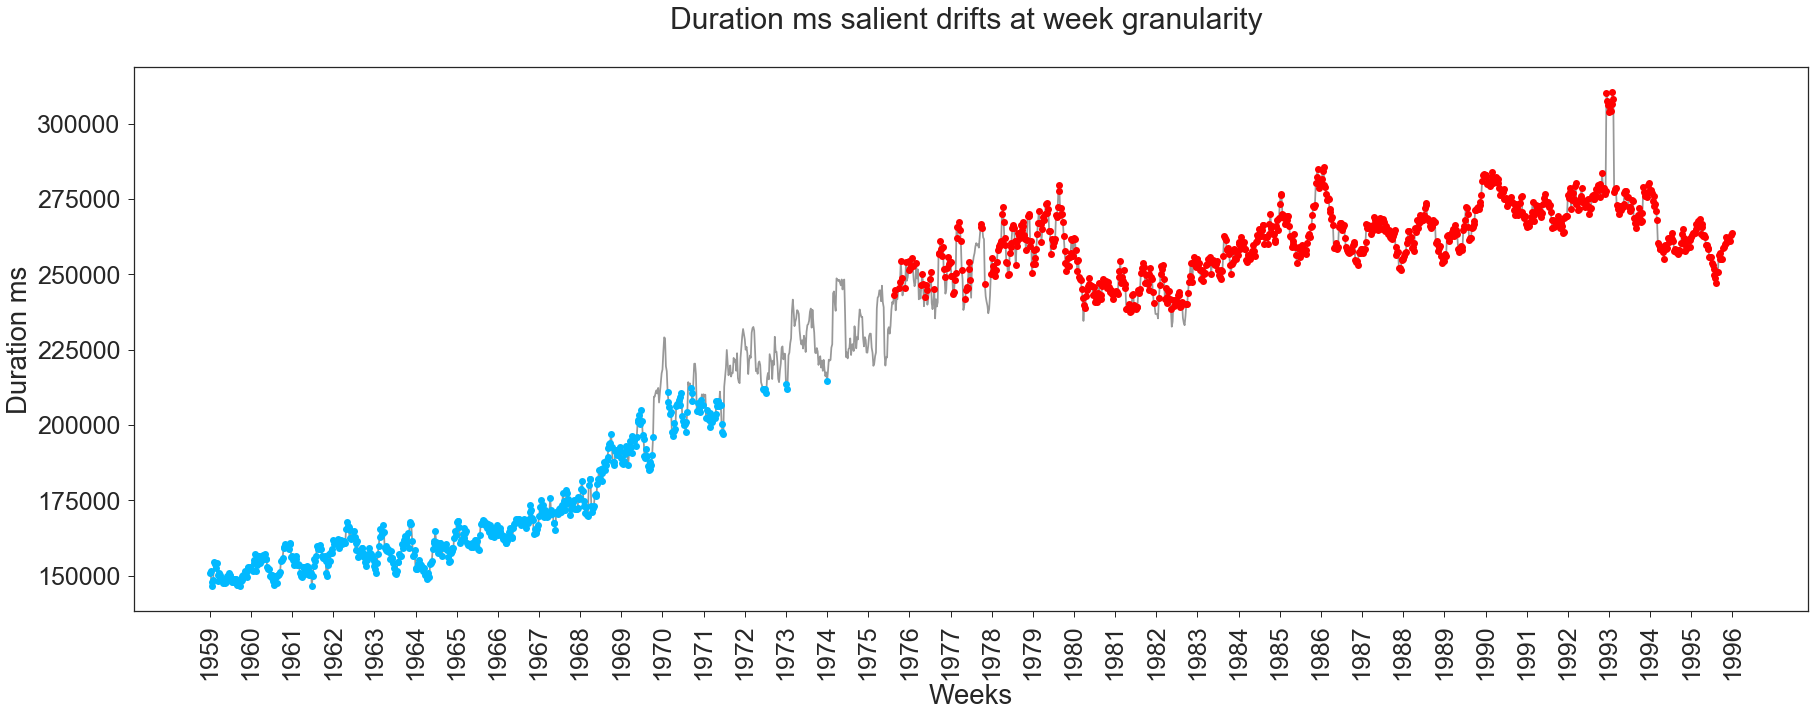

In [33]:
feature = 'duration_ms'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

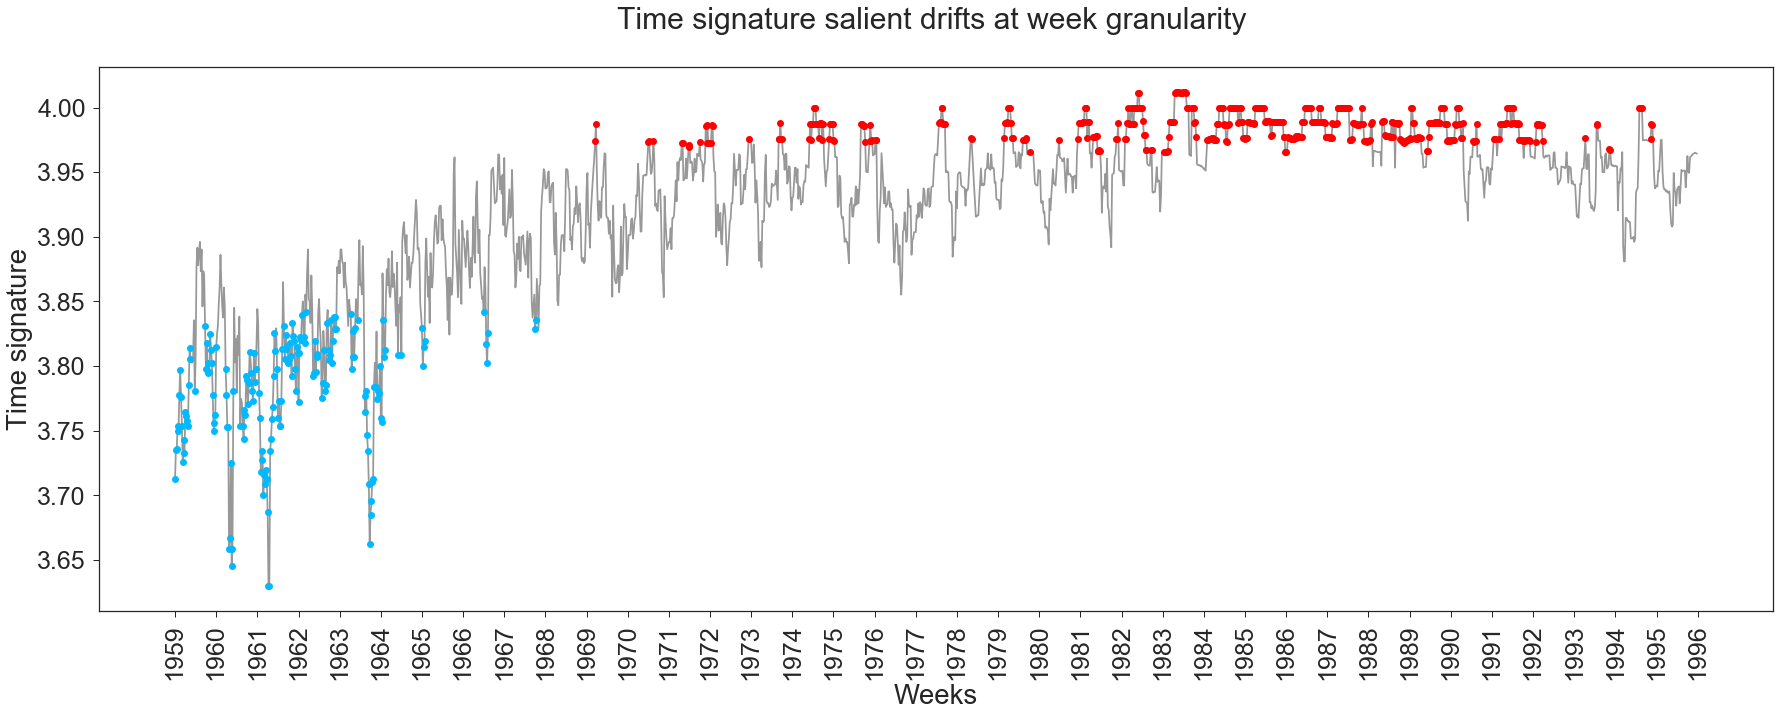

In [34]:
feature = 'time_signature'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

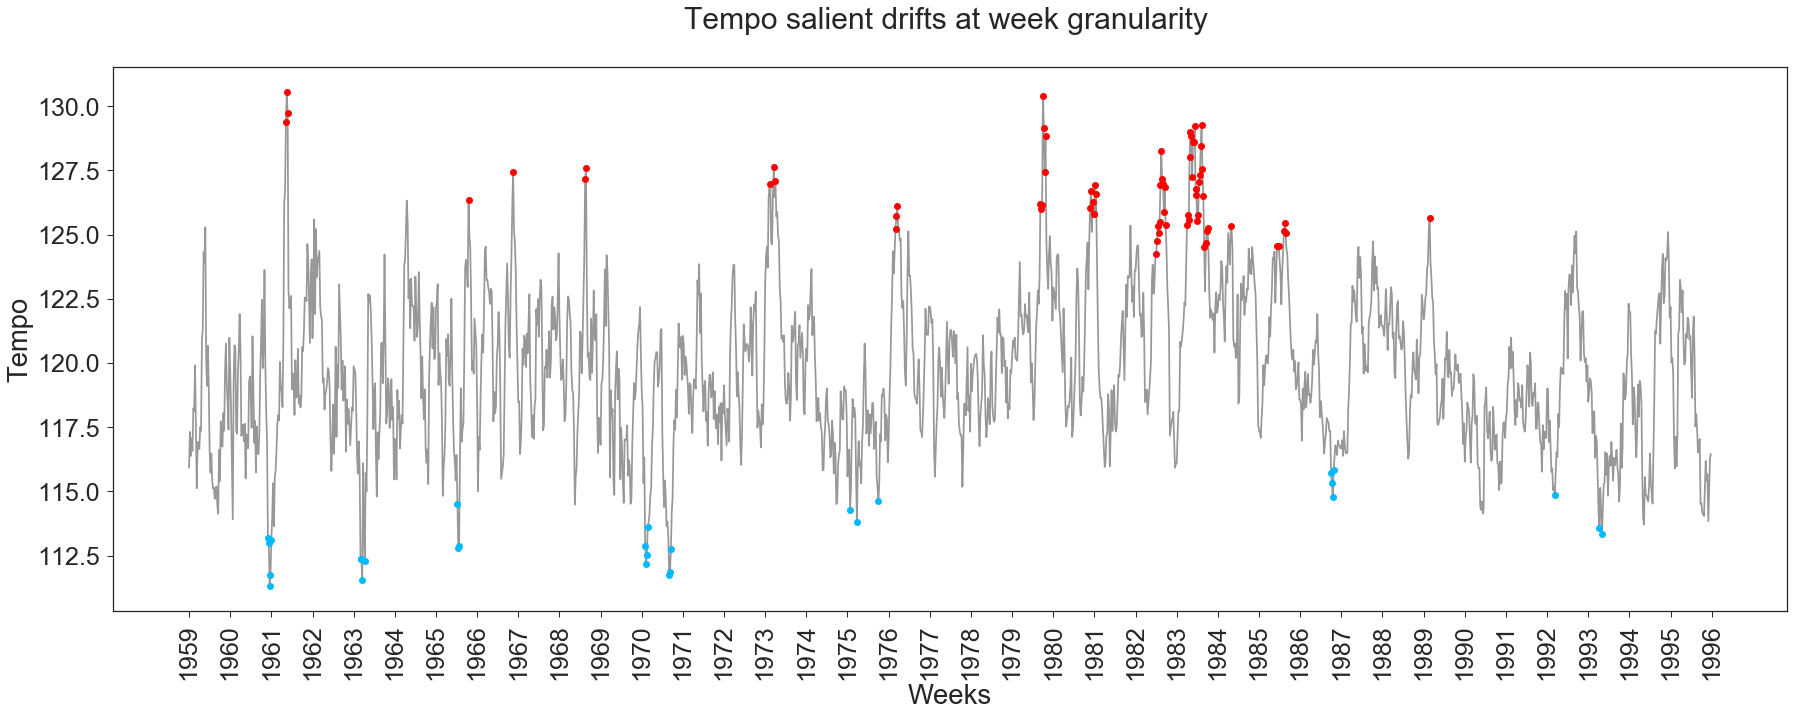

In [35]:
feature = 'tempo'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

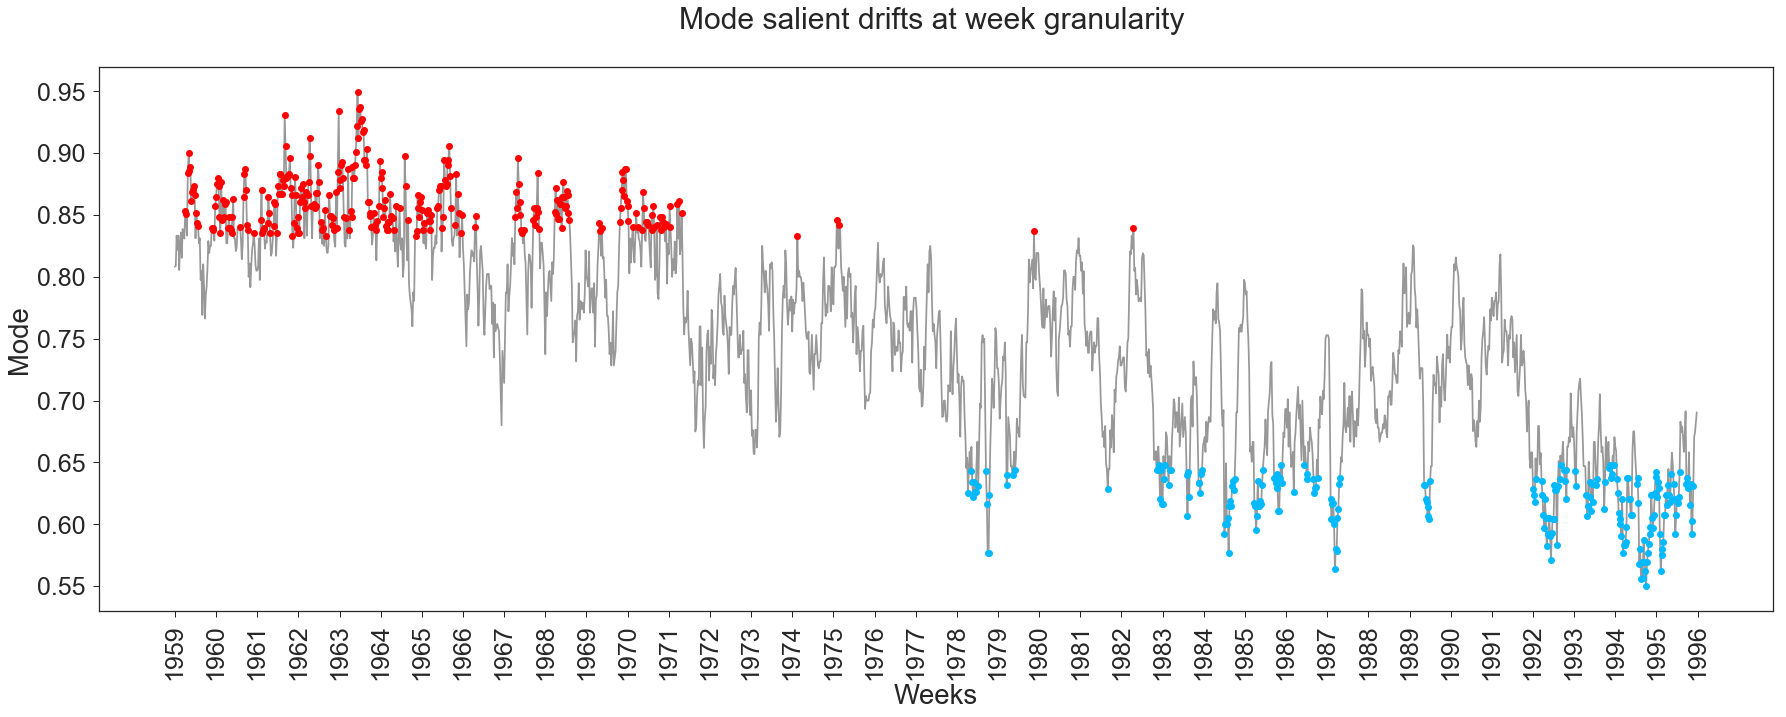

In [36]:
feature = 'mode'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

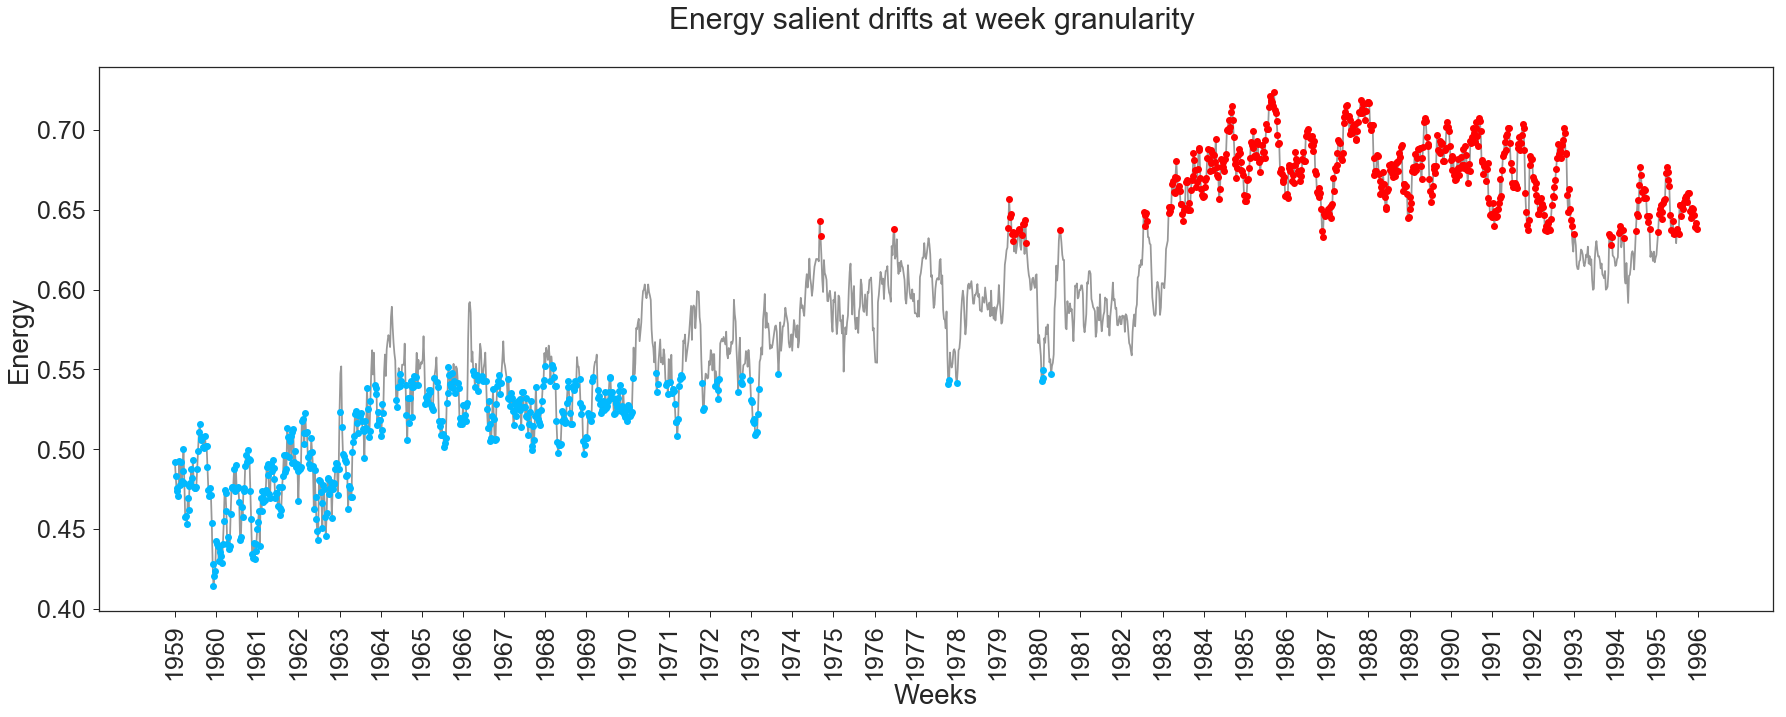

In [37]:
feature = 'energy'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

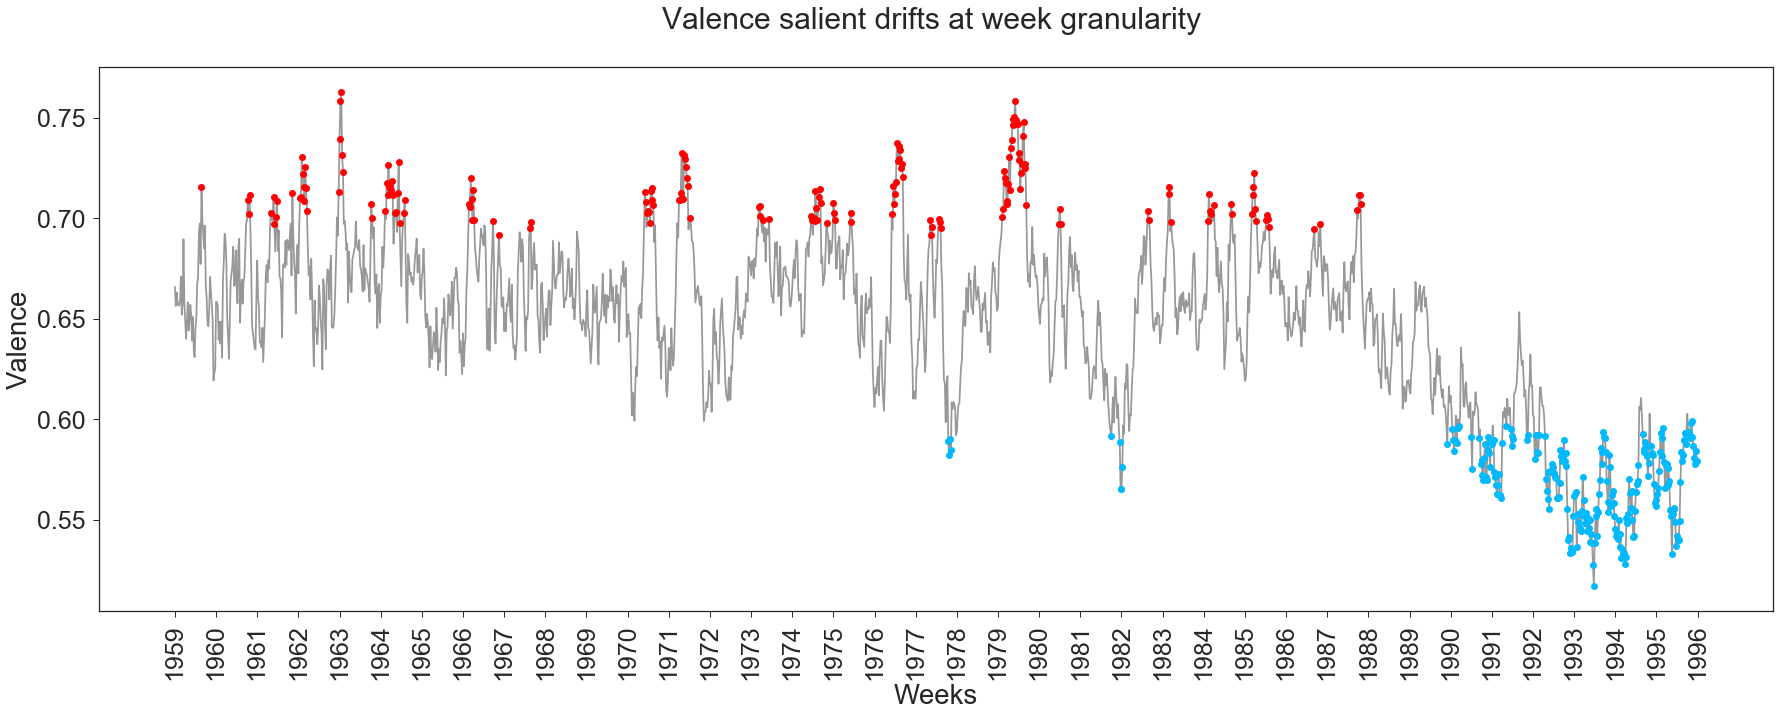

In [38]:
feature = 'valence'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

In [39]:
explanative_features = ['root', 'loudness', 'time_signature', 'tempo', 'mode', 'valence']
keep_low, keep_high = [], []

for key in salient_low_list.keys():
    if (key != 'duration_ms') & (key != 'energy'):
        for element in salient_low_list[key]:
            keep_low.append(element)

for key in salient_high_list.keys():
    if (key != 'duration_ms') & (key != 'energy'):
        for element in salient_high_list[key]:
            keep_high.append(element)

In [40]:
keep_low = pd.Series(keep_low).value_counts()
keep_high = pd.Series(keep_high).value_counts()

In [41]:
weeks = pd.Series(weeks)

In [42]:
salient_low = keep_low[keep_low.values >= 4].index
weeks[salient_low].sort_values()

Series([], dtype: object)

In [43]:
salient_high = keep_high[keep_high.values >= 4].index
weeks[salient_high].sort_values()

Series([], dtype: object)

# Months

In [44]:
months_list = []

for ind, item in df['weeks_list'].iteritems():
    occurences = [] 
    
    for week in item:
        month = week[:7]
        if not(month in occurences):
            occurences.append(month)
            
    months_list.append(occurences)
    
df['months_list'] = months_list

In [45]:
all_months = []

for ind, item in df['months_list'].iteritems():
    for month in item:
        all_months.append(month)
        
months = pd.Series(all_months).value_counts().index

In [46]:
months = sorted(months)[1:]

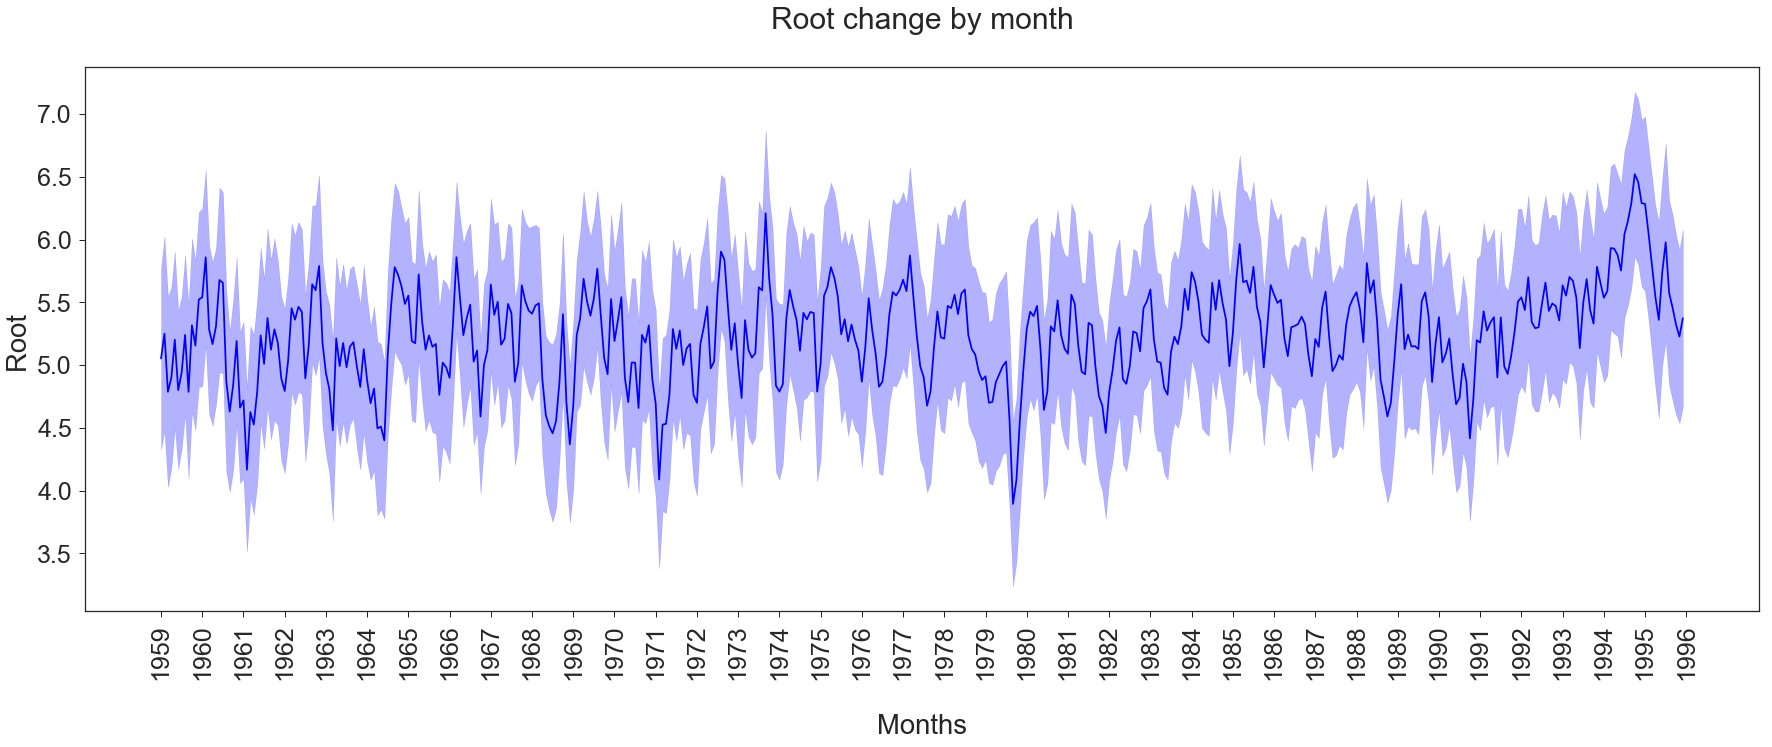

In [47]:
plot_feature_evolution(monthly_features, 'root', N = 12, granularity = 'Months');

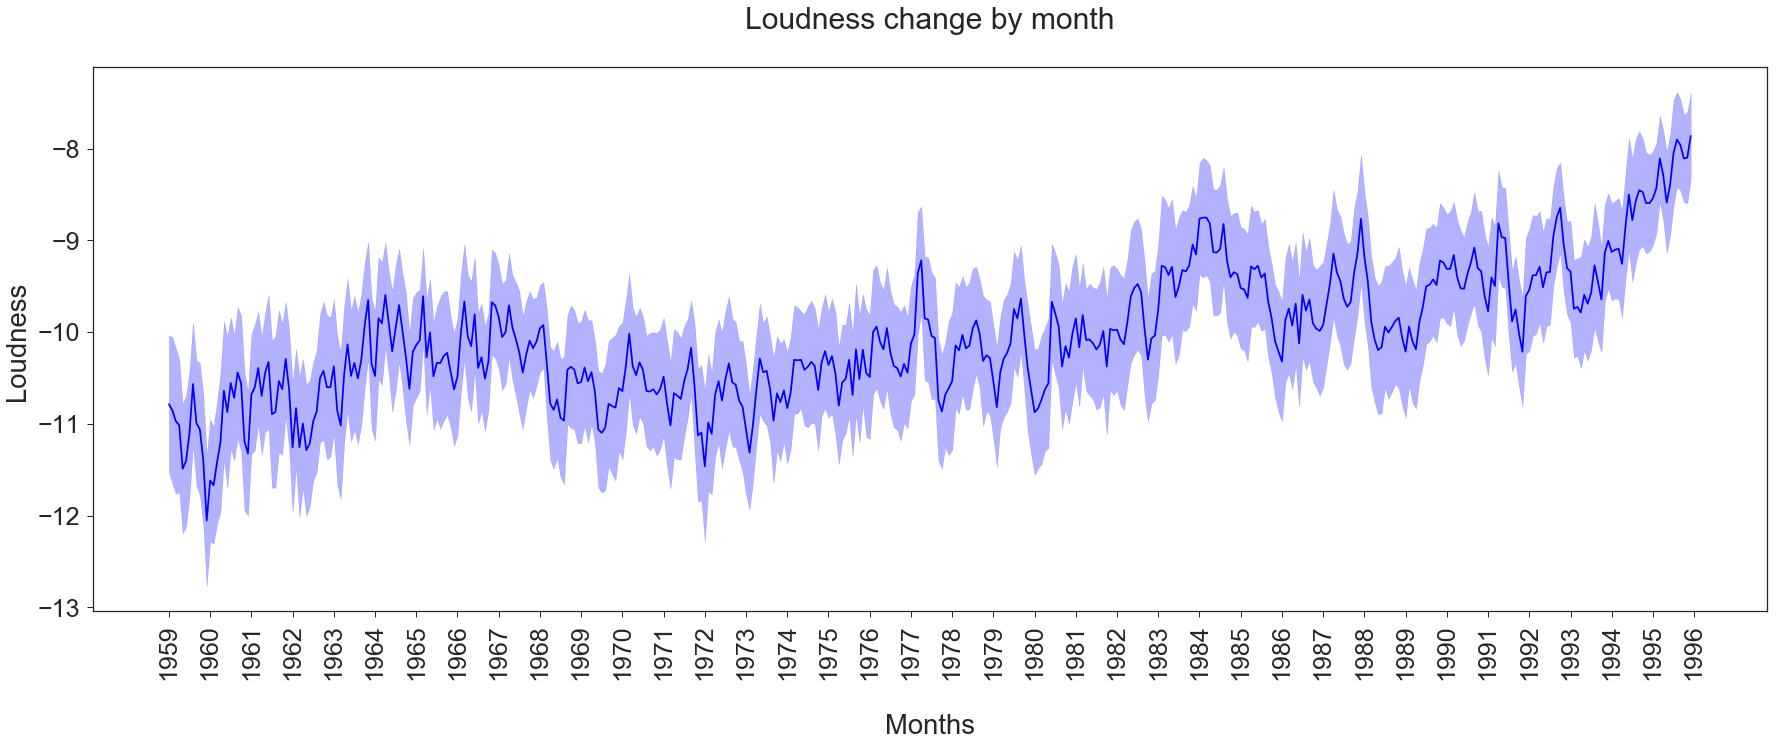

In [48]:
plot_feature_evolution(monthly_features, 'loudness', N = 12, granularity = 'Months');

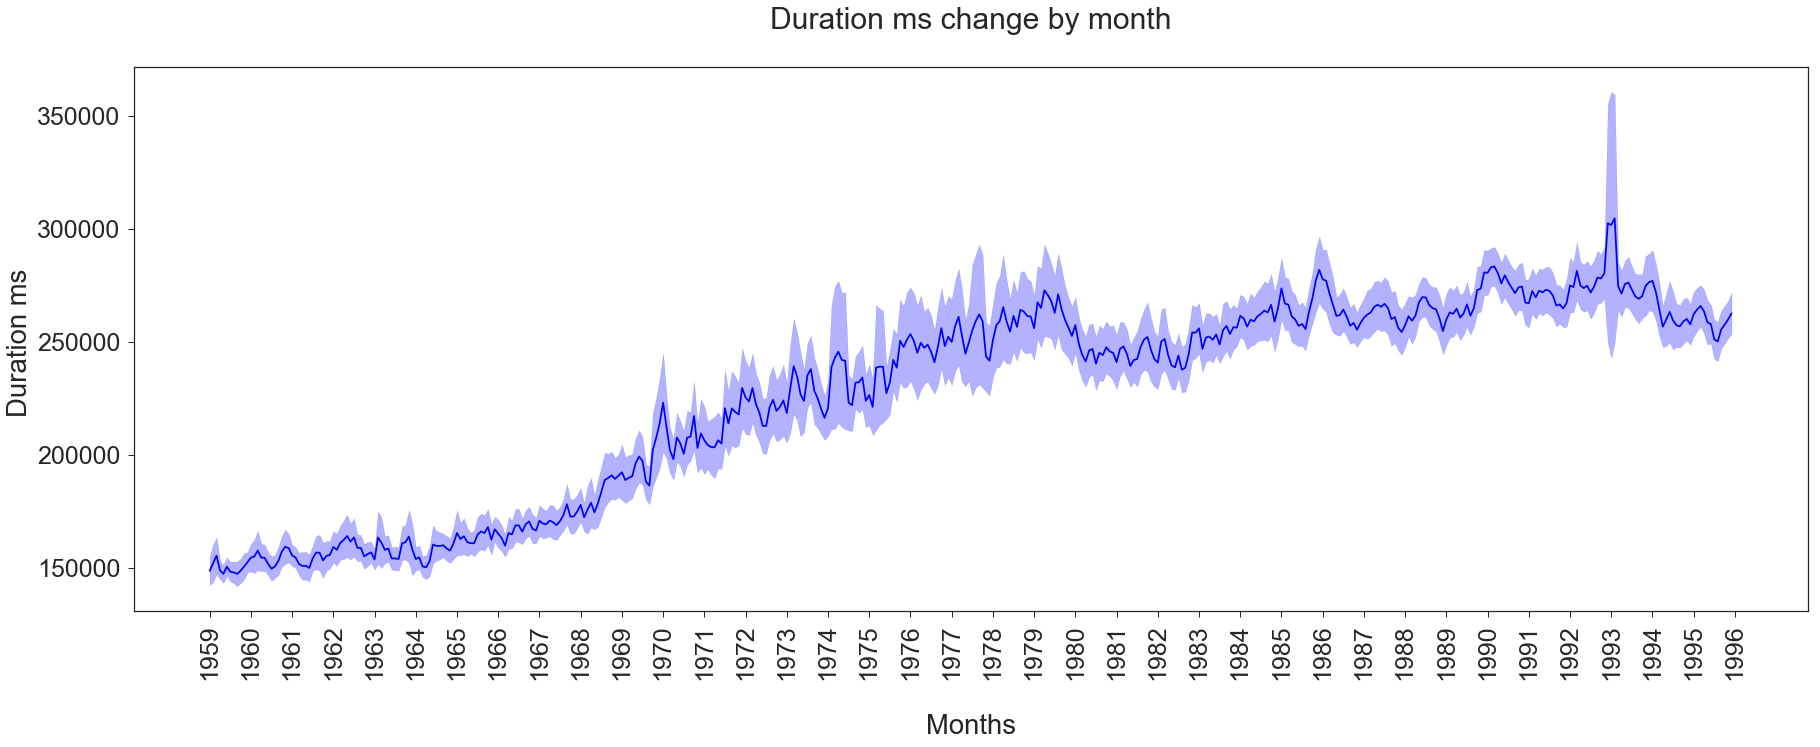

In [49]:
plot_feature_evolution(monthly_features, 'duration_ms', N = 12, granularity = 'Months');

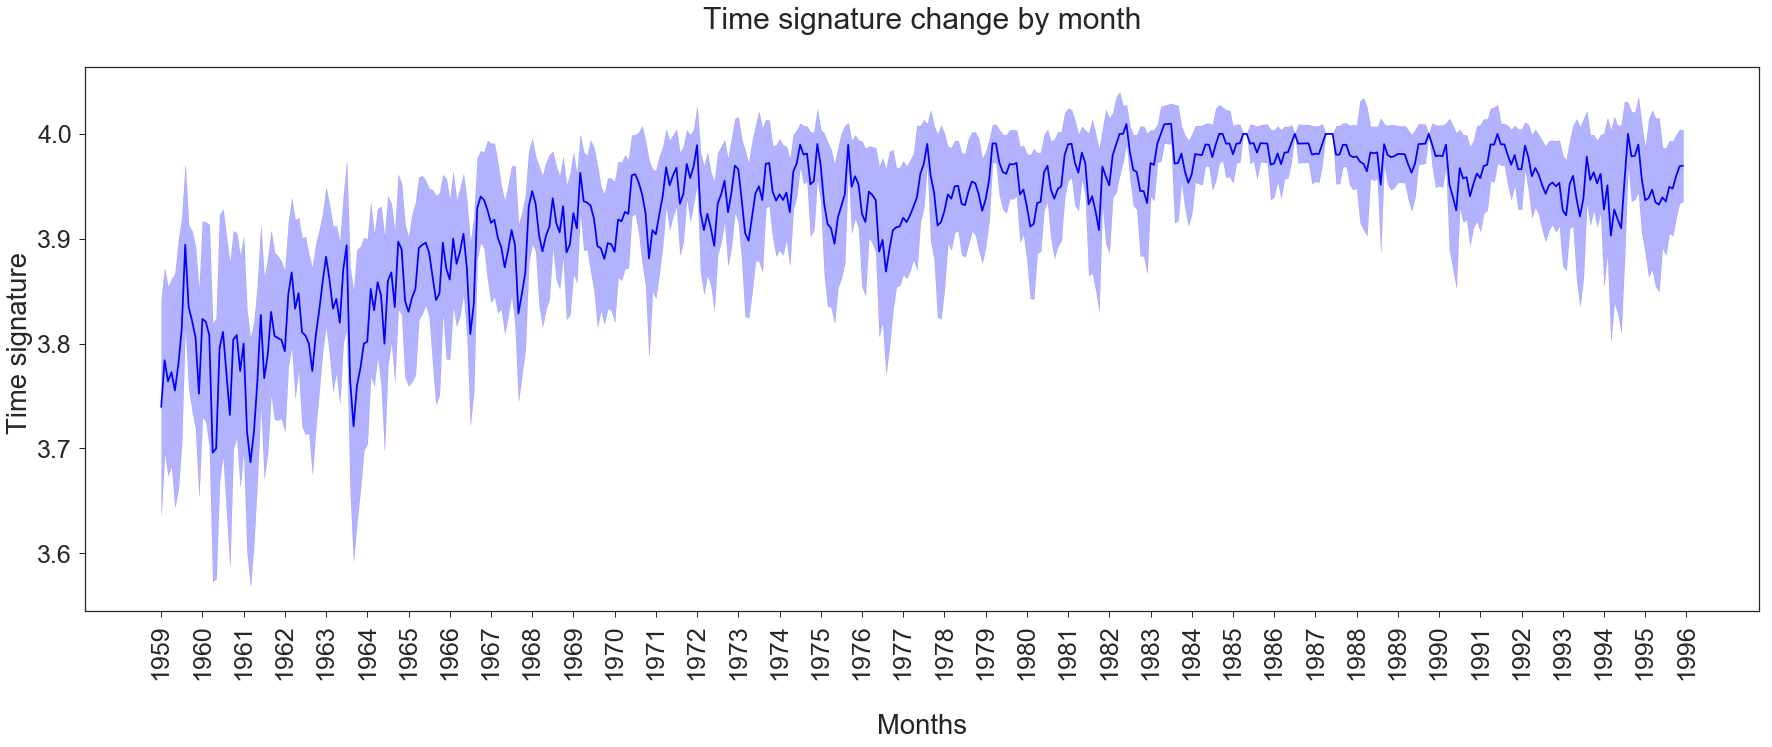

In [50]:
plot_feature_evolution(monthly_features, 'time_signature', N = 12, granularity = 'Months');

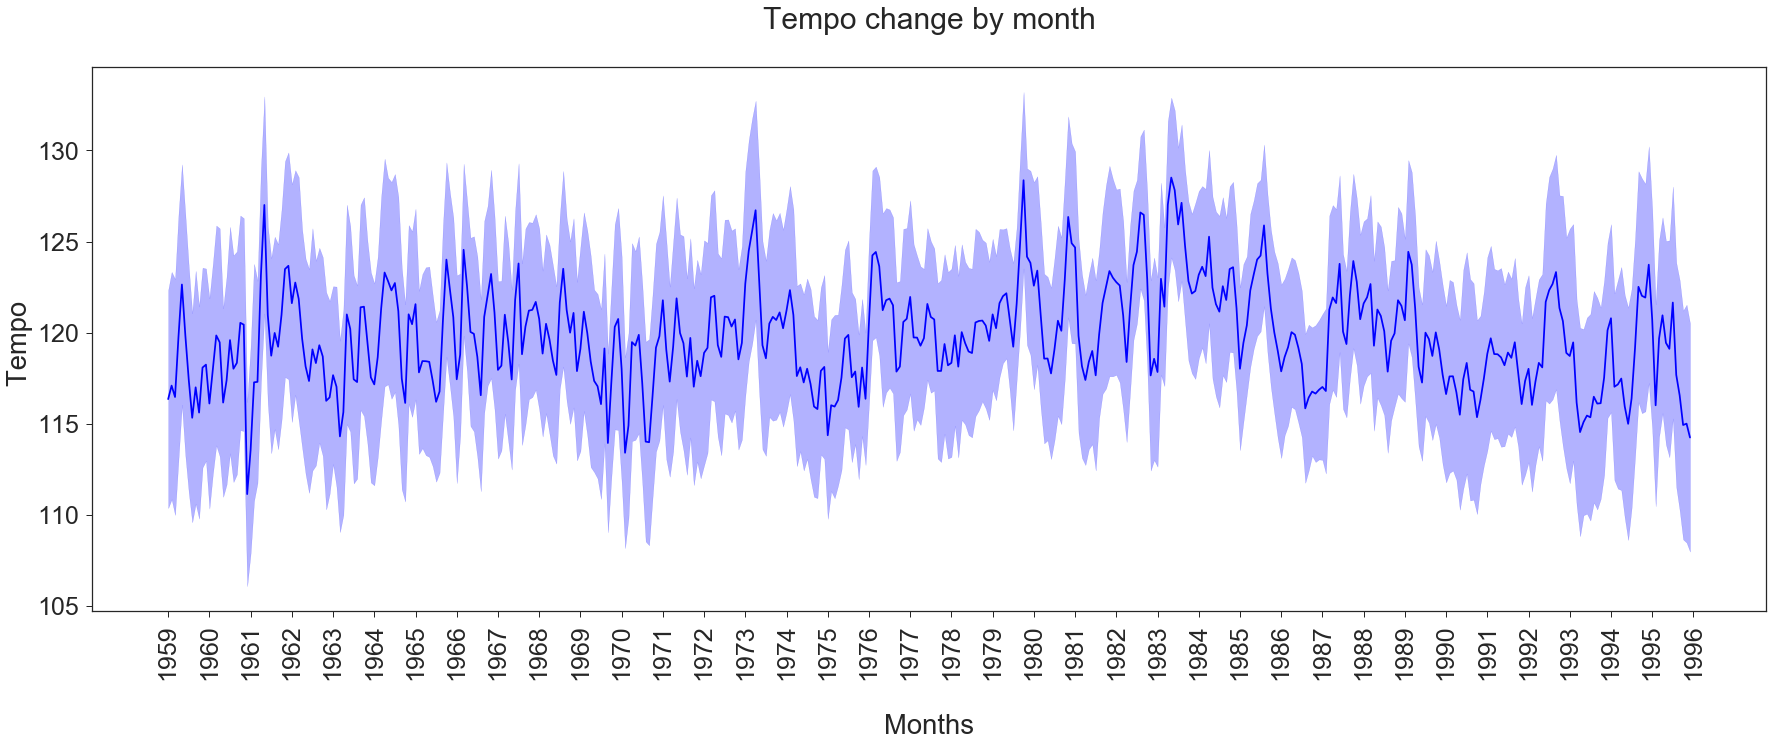

In [51]:
plot_feature_evolution(monthly_features, 'tempo', N = 12, granularity = 'Months');

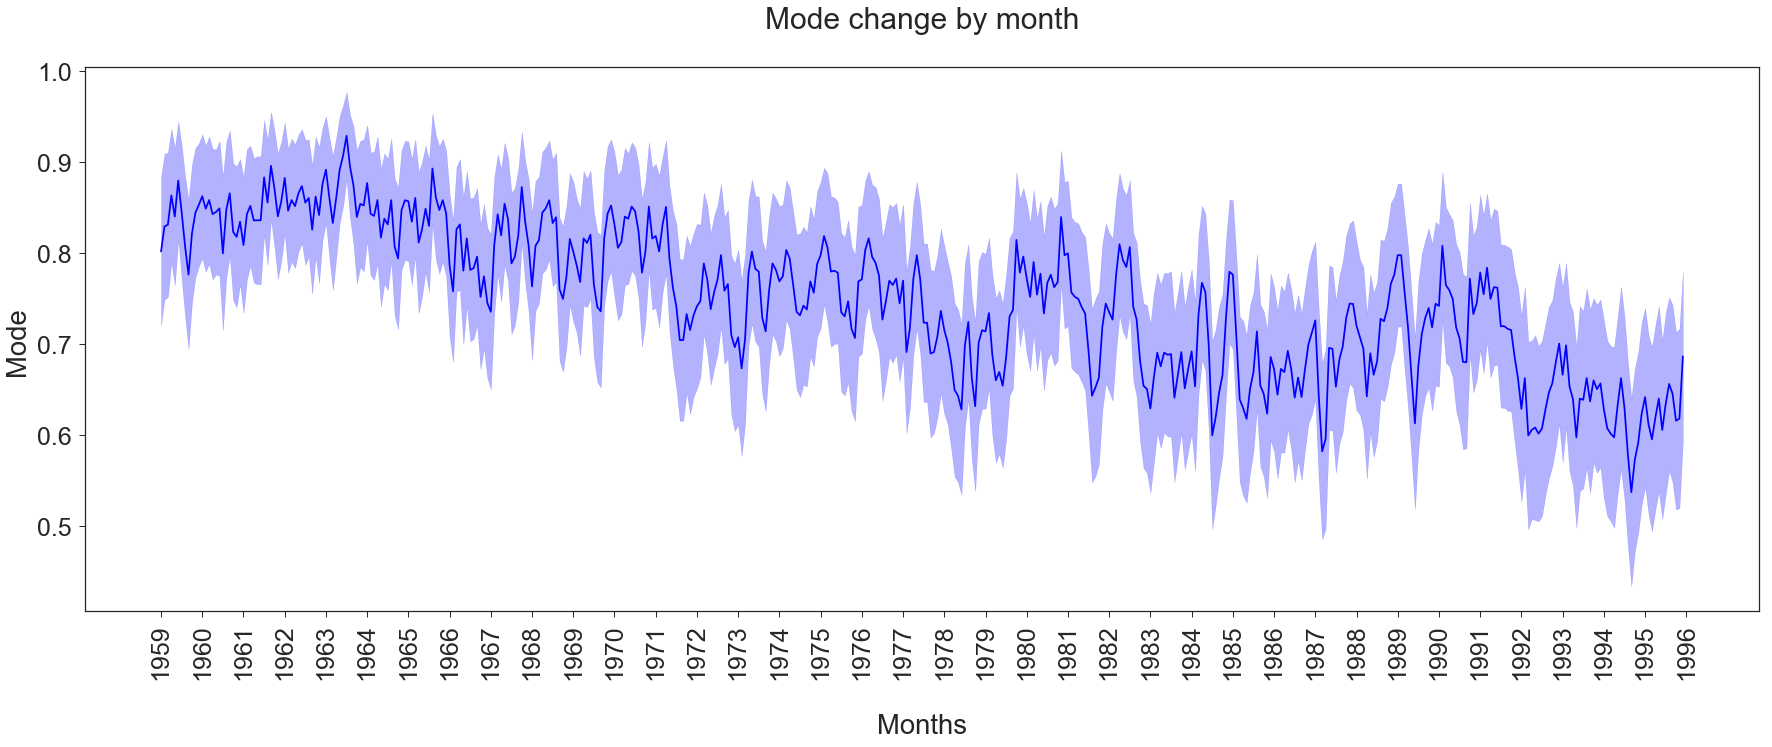

In [52]:
plot_feature_evolution(monthly_features, 'mode', N = 12, granularity = 'Months');

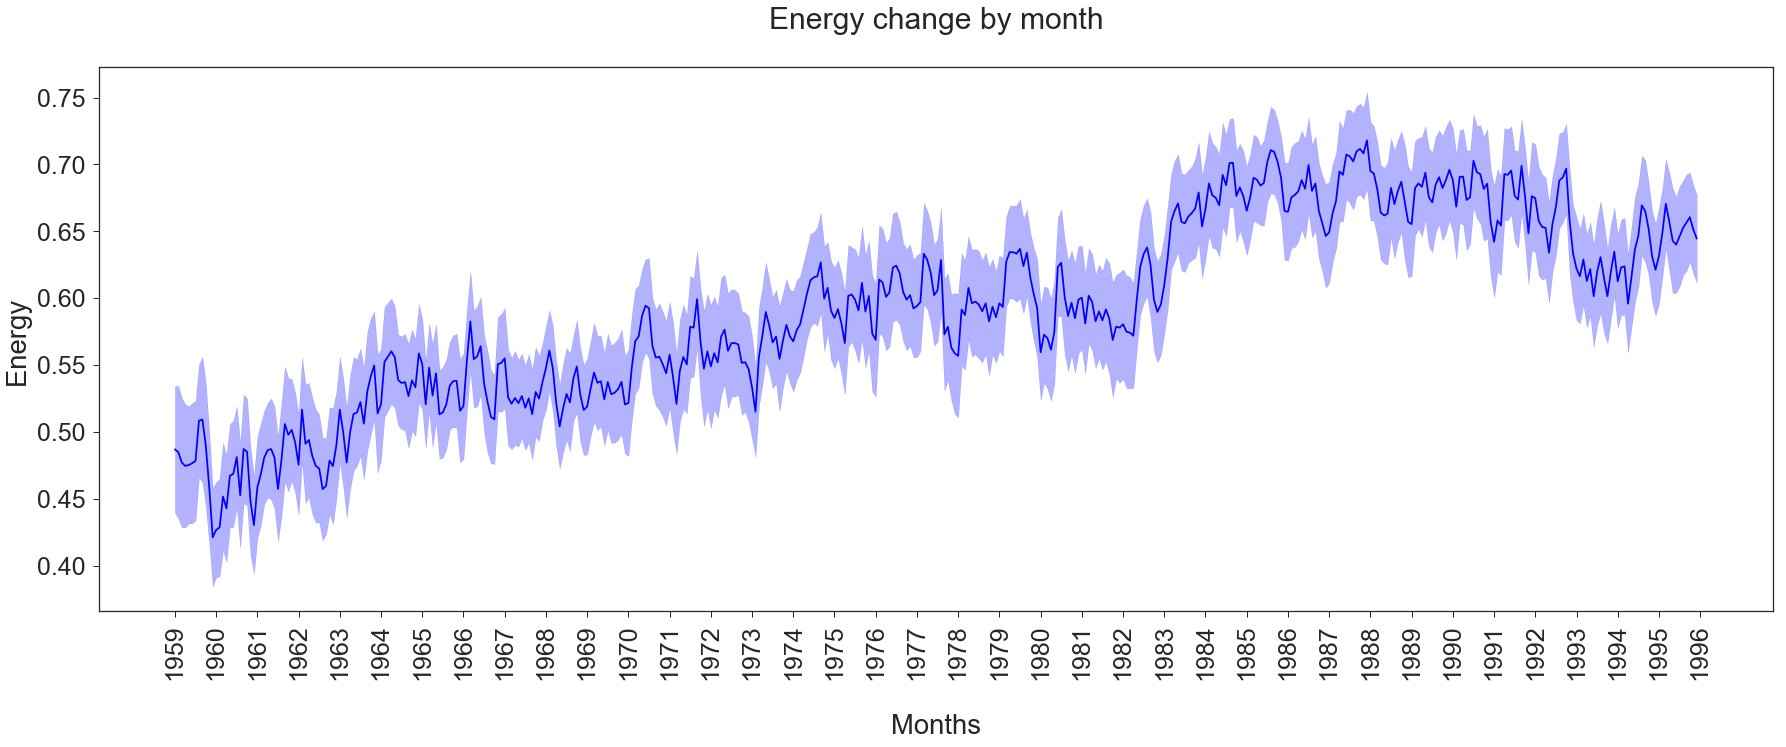

In [53]:
plot_feature_evolution(monthly_features, 'energy', N = 12, granularity = 'Months');

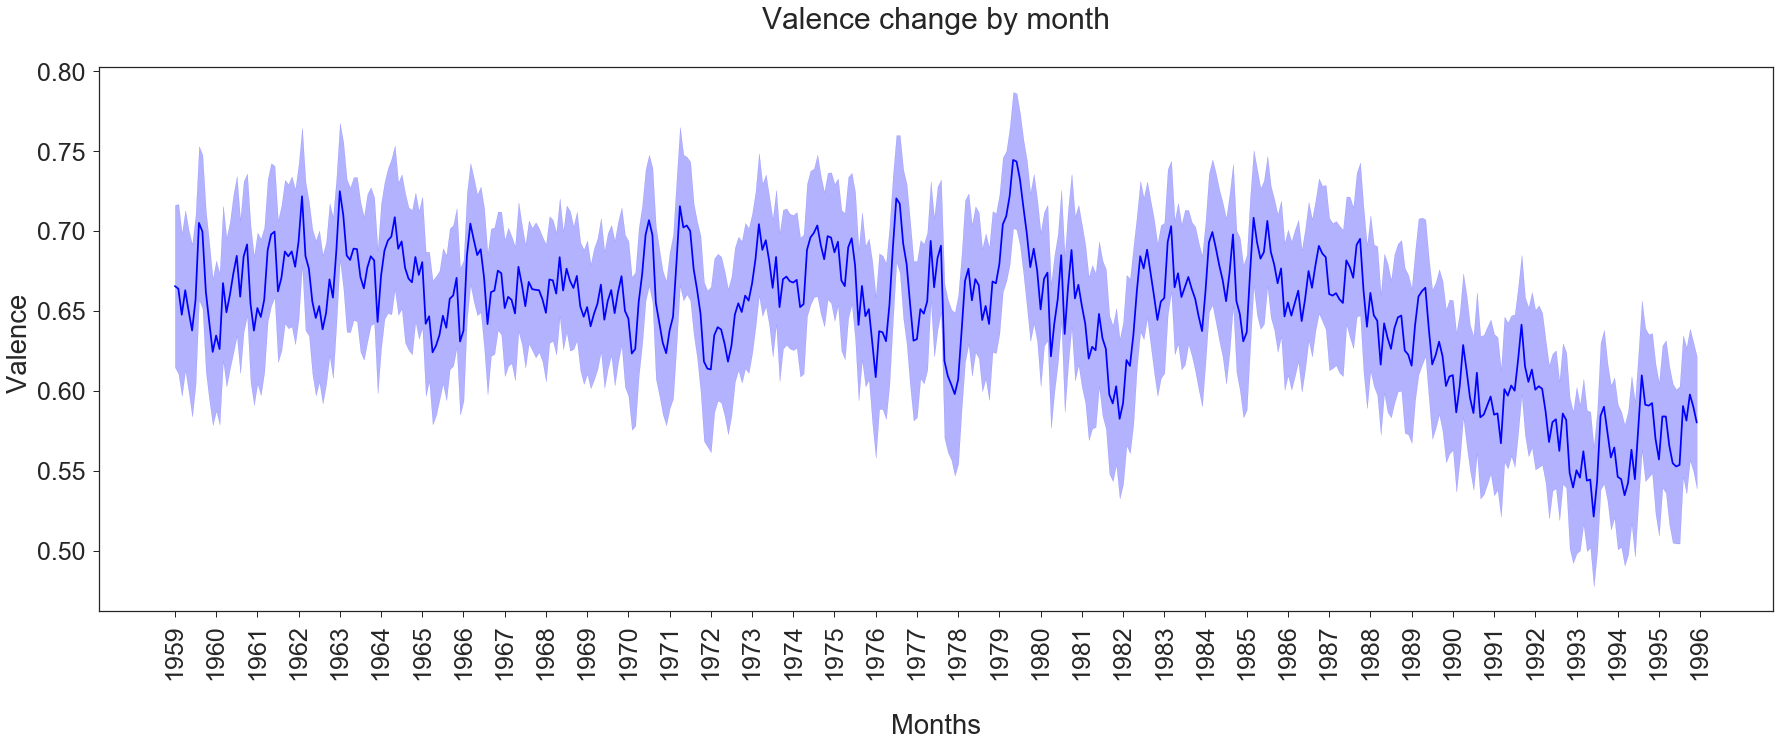

In [54]:
plot_feature_evolution(monthly_features, 'valence', N = 12, granularity = 'Months');

# Years

In [55]:
years_list = []

for ind, item in df['weeks_list'].iteritems():
    occurences = [] 
    
    for week in item:
        year = week[:4]
        if not(year in occurences):
            occurences.append(year)
            
    years_list.append(occurences)
    
df['years_list'] = years_list

In [56]:
all_years = []

for ind, item in df['years_list'].iteritems():
    for year in item:
        all_years.append(year)
        
years = pd.Series(all_years).value_counts().index

In [57]:
years = sorted(years)[1:]

In [58]:
yearly_features = pd.DataFrame(yearly_features)

In [59]:
yearly_features.head()

root  \
0   [0, 2, 2, 4, 4, 7, 0, 0, 6, 10, 10, 7, 4, 10, ...   
1   [2, 3, 2, 0, 0, 9, 4, 10, 2, 7, 4, 10, 7, 0, 2...   
10  [7, 1, 2, 0, 10, 4, 11, 9, 0, 0, 10, 4, 9, 4, ...   
11  [11, 7, 9, 9, 9, 5, 0, 5, 5, 2, 9, 2, 7, 6, 9,...   
12  [2, 9, 4, 3, 11, 6, 0, 3, 1, 0, 2, 11, 2, 9, 2...   

                                             loudness  \
0   [-12.486, -10.251, -7.414, -15.295, -15.353, -...   
1   [-11.124, -14.803, -10.777, -11.434, -14.201, ...   
10  [-9.016, -7.719, -11.927, -9.505, -7.7, -14.98...   
11  [-14.195, -8.302, -6.31, -10.147, -5.41, -12.3...   
12  [-10.316, -5.25, -9.275, -15.414, -8.283, -6.2...   

                                          duration_ms  \
0   [134000, 189733, 145227, 145867, 107317, 11129...   
1   [169373, 185440, 137800, 161067, 121267, 14149...   
10  [181067, 172400, 279280, 173987, 425653, 27157...   
11  [192040, 153453, 229400, 322360, 164600, 19870...   
12  [158333, 255832, 199933, 227787, 154440, 23773...   

                                       time_signature  \
0   [4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...   
1   [3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, ...   
10  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...   
11  [4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...   
12  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, ...   

                                                tempo  \
0   [165.234, 79.168, 97.239, 115.643, 85.189, 118...   
1   [110.325, 169.36, 106.438, 117.257, 114.741, 7...   
10  [174.284, 115.918, 103.064, 119.44, 147.207, 1...   
11  [69.77, 79.181, 81.851, 102.773, 118.051, 149....   
12  [120.643, 121.958, 113.076, 83.342, 107.017, 1...   

                                                 mode  \
0   [1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, ...   
1   [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, ...   
10  [1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, ...   
11  [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
12  [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                               energy  \
0   [0.763, 0.364, 0.888, 0.28800000000000003, 0.4...   
1   [0.381, 0.193, 0.376, 0.505, 0.294, 0.454, 0.7...   
10  [0.41100000000000003, 0.652, 0.492, 0.526, 0.6...   
11  [0.488, 0.586, 0.375, 0.844, 0.673, 0.25, 0.38...   
12  [0.382, 0.674, 0.6970000000000001, 0.204000000...   

                                              valence  
0   [0.965, 0.178, 0.851, 0.361, 0.829000000000000...  
1   [0.486, 0.342, 0.884, 0.862, 0.683, 0.746, 0.7...  
10  [0.334, 0.962, 0.58, 0.771, 0.532, 0.801, 0.93...  
11  [0.707, 0.842, 0.494, 0.519, 0.615, 0.382, 0.4...  
12  [0.795, 0.6000000000000001, 0.876, 0.524, 0.92...

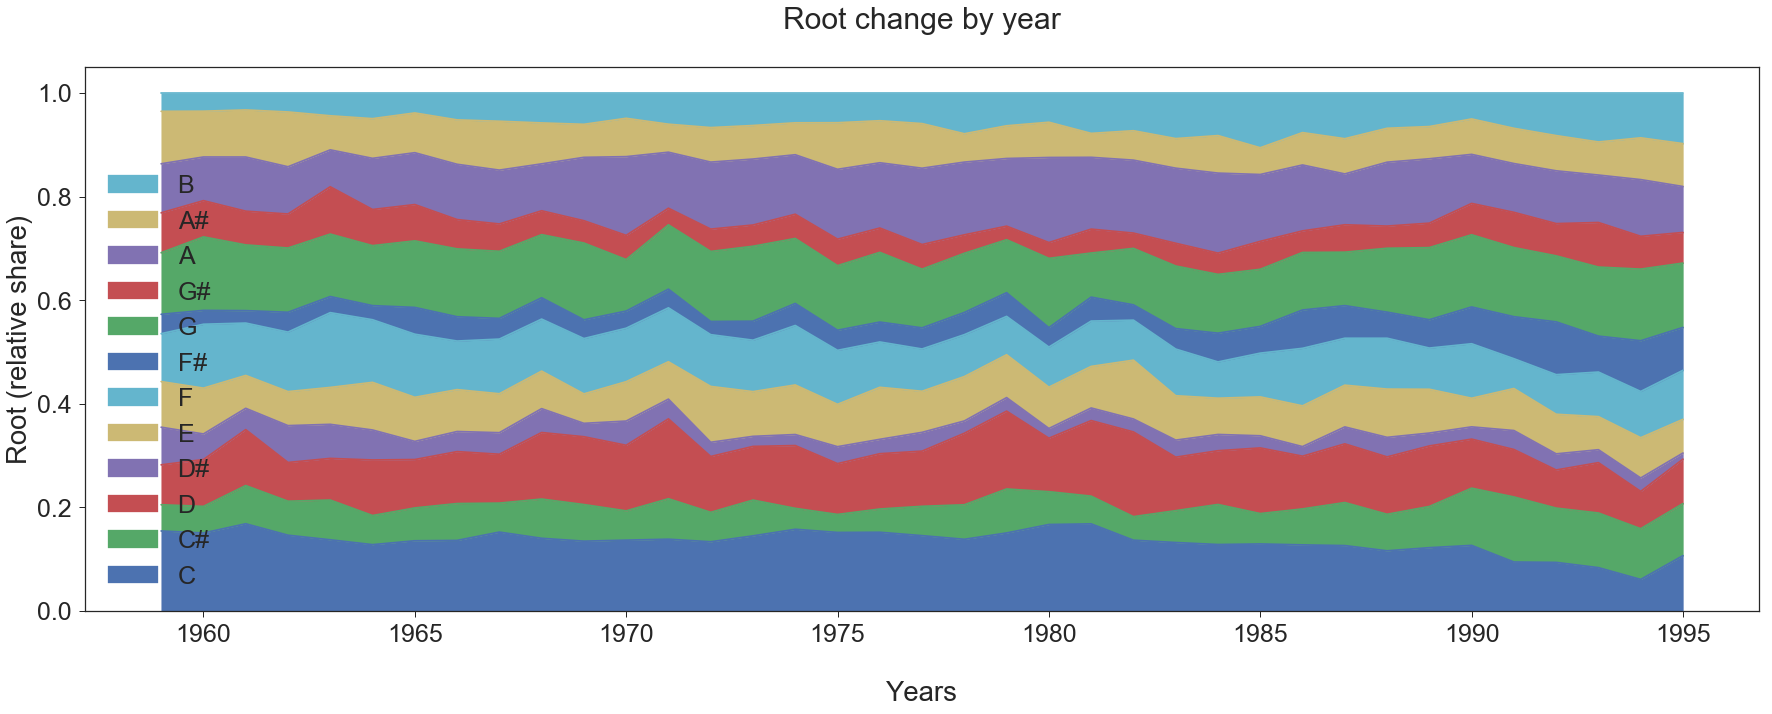

In [60]:
plot_discrete_feature_evolution(yearly_features, 'root', granularity = 'Years', categories =
                               ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']);

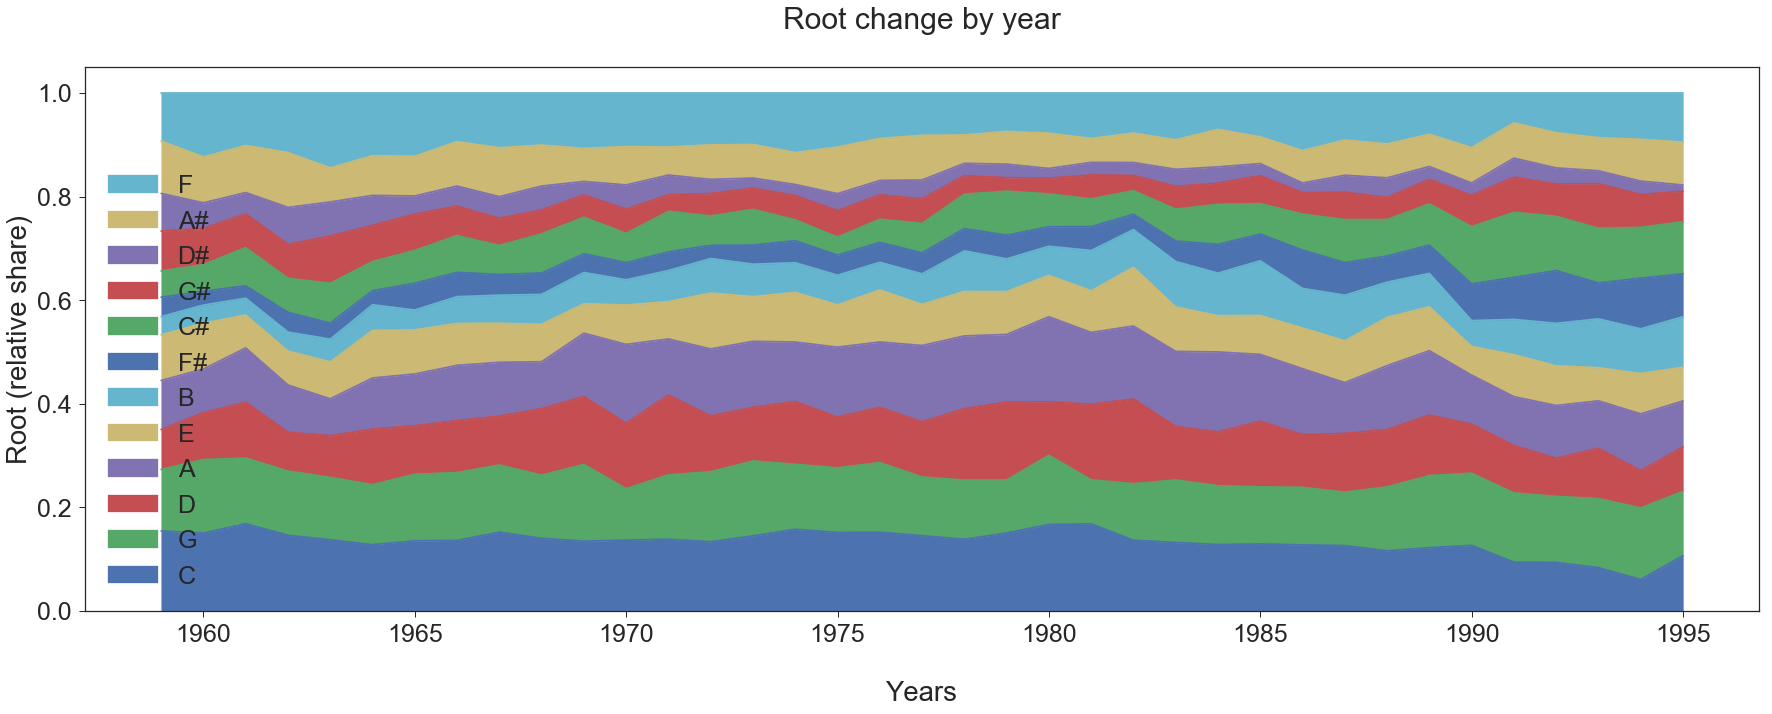

In [61]:
plot_discrete_feature_evolution(yearly_features, 'root', granularity = 'Years', categories =
                               ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'],
                               reorder = ['C', 'G', 'D', 'A', 'E', 'B', 'F#', 'C#', 'G#', 'D#', 'A#', 'F']);

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

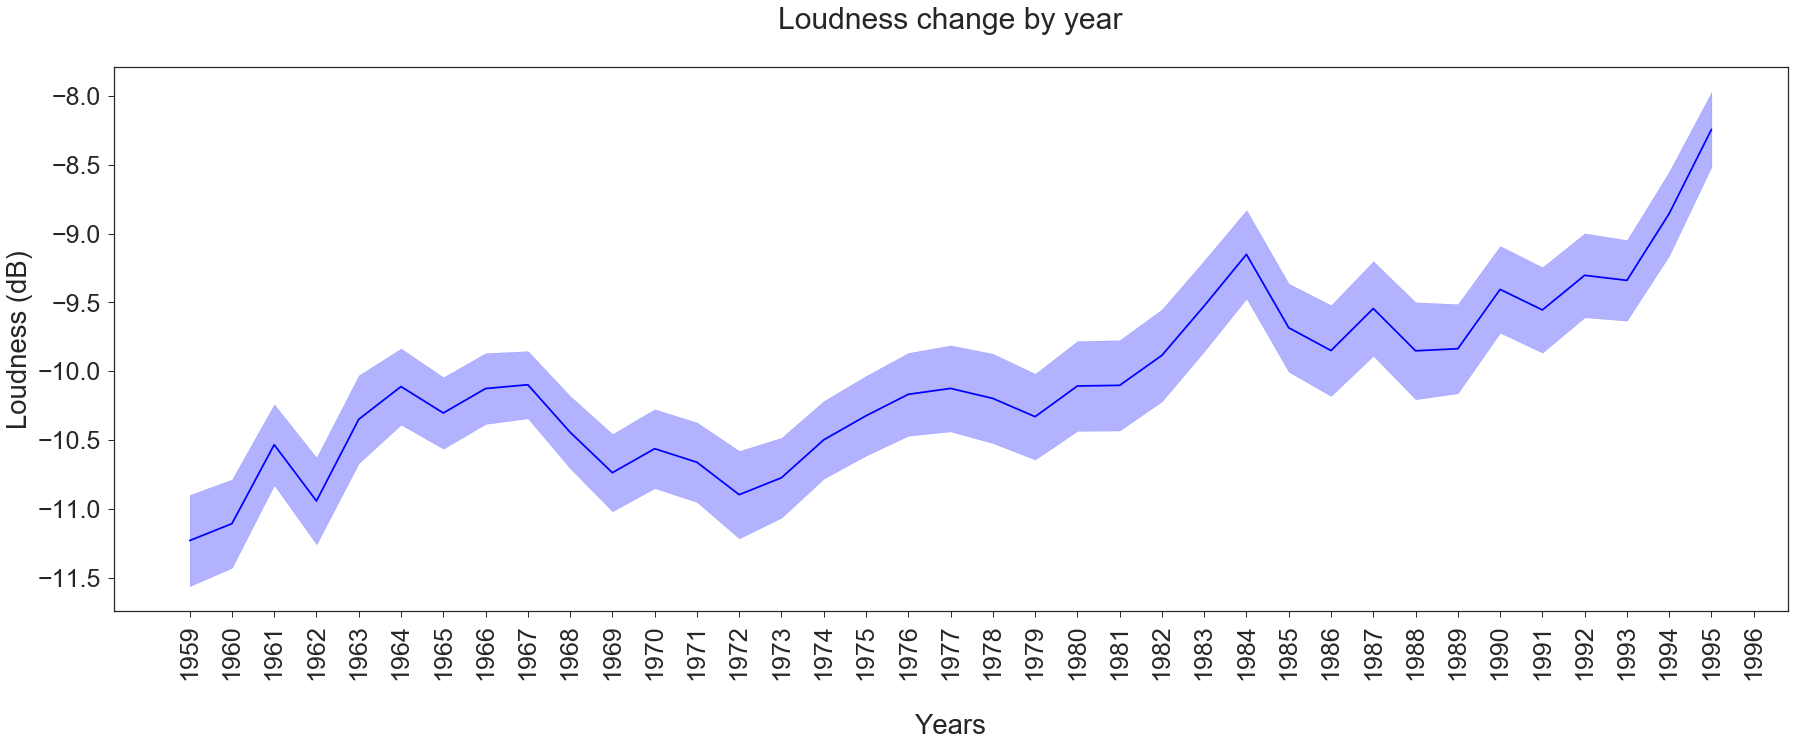

In [62]:
plot_feature_evolution(yearly_features, 'loudness', N = 1, granularity = 'Years', unit = '(dB)')

In [63]:
yearly_features = yearly_features.rename(columns = {'duration_ms':'duration'})

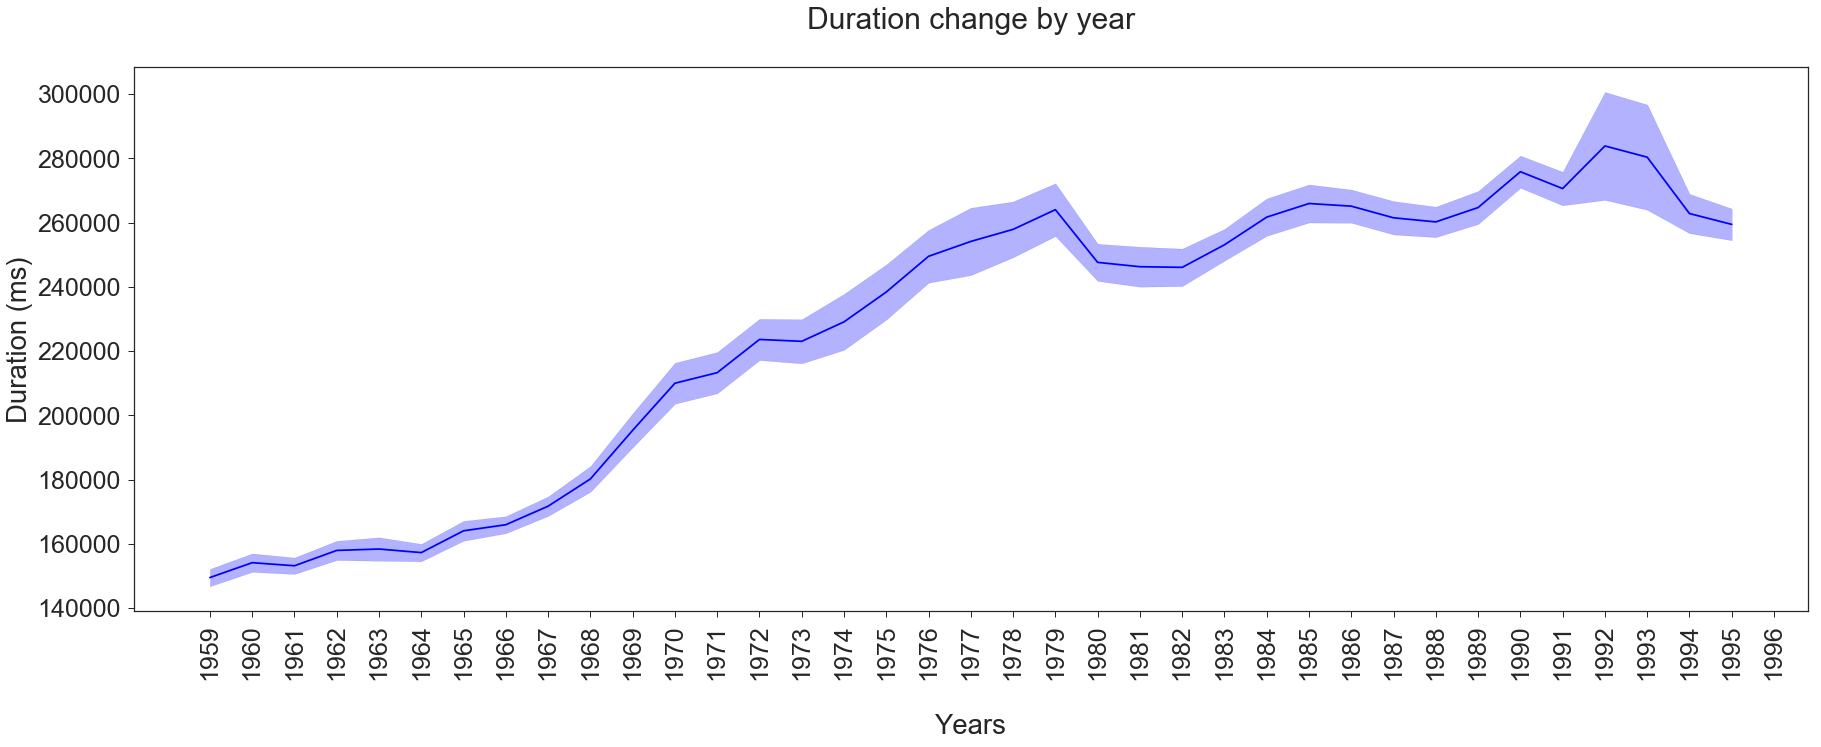

In [64]:
plot_feature_evolution(yearly_features, 'duration', N = 1, granularity = 'Years', unit = '(ms)');

In [65]:
yearly_features = yearly_features.rename(columns = {'duration':'duration_ms'})

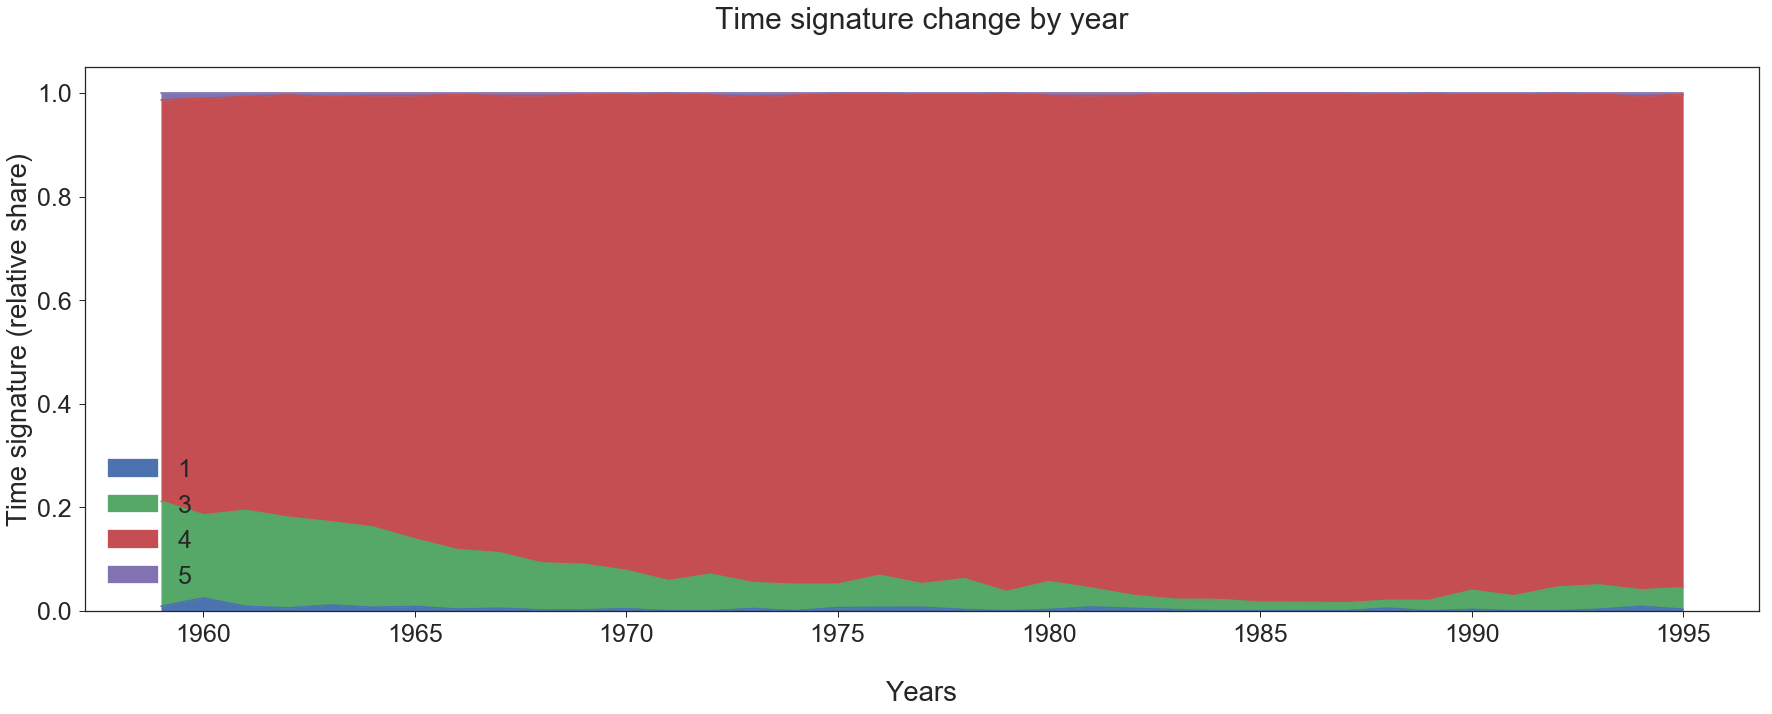

In [66]:
ax = plot_discrete_feature_evolution(yearly_features, 'time_signature', granularity = 'Years');
ax.legend(loc=3)

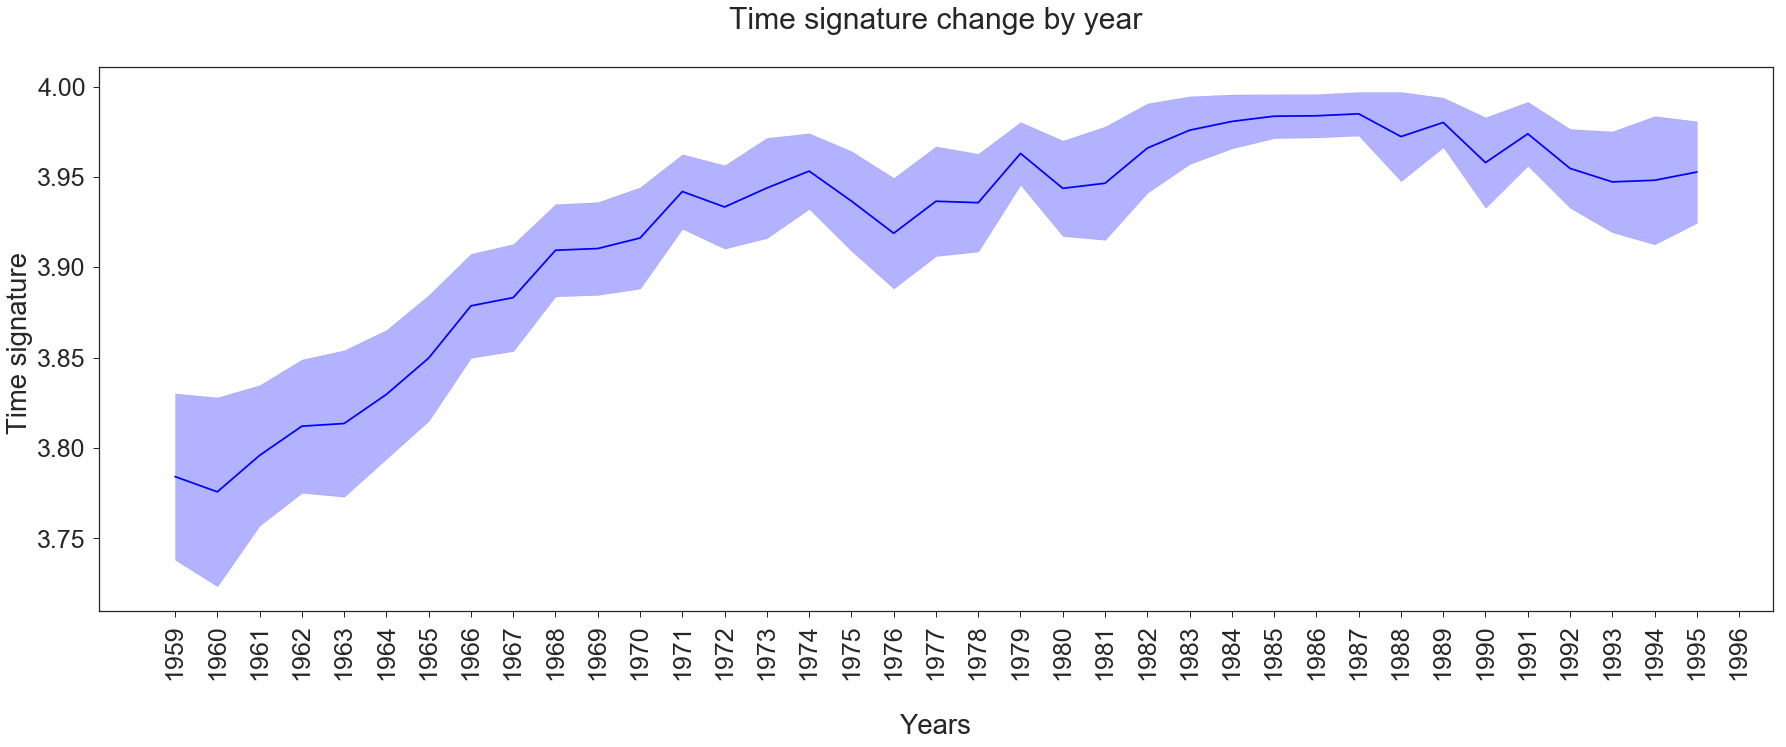

In [67]:
plot_feature_evolution(yearly_features, 'time_signature', N = 1, granularity = 'Years');

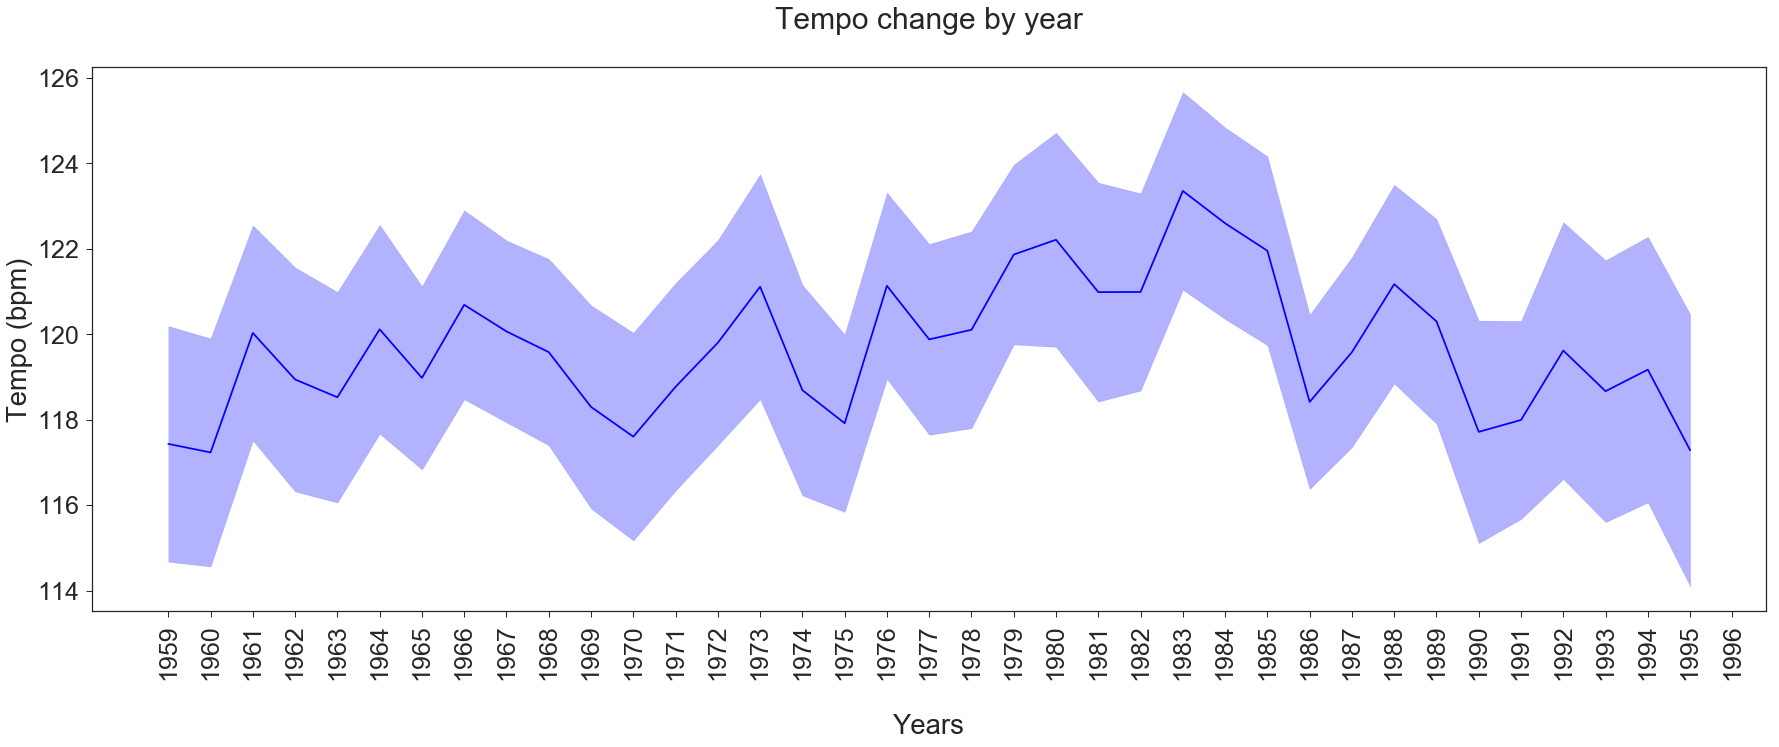

In [68]:
plot_feature_evolution(yearly_features, 'tempo', N = 1, granularity = 'Years', unit = '(bpm)');

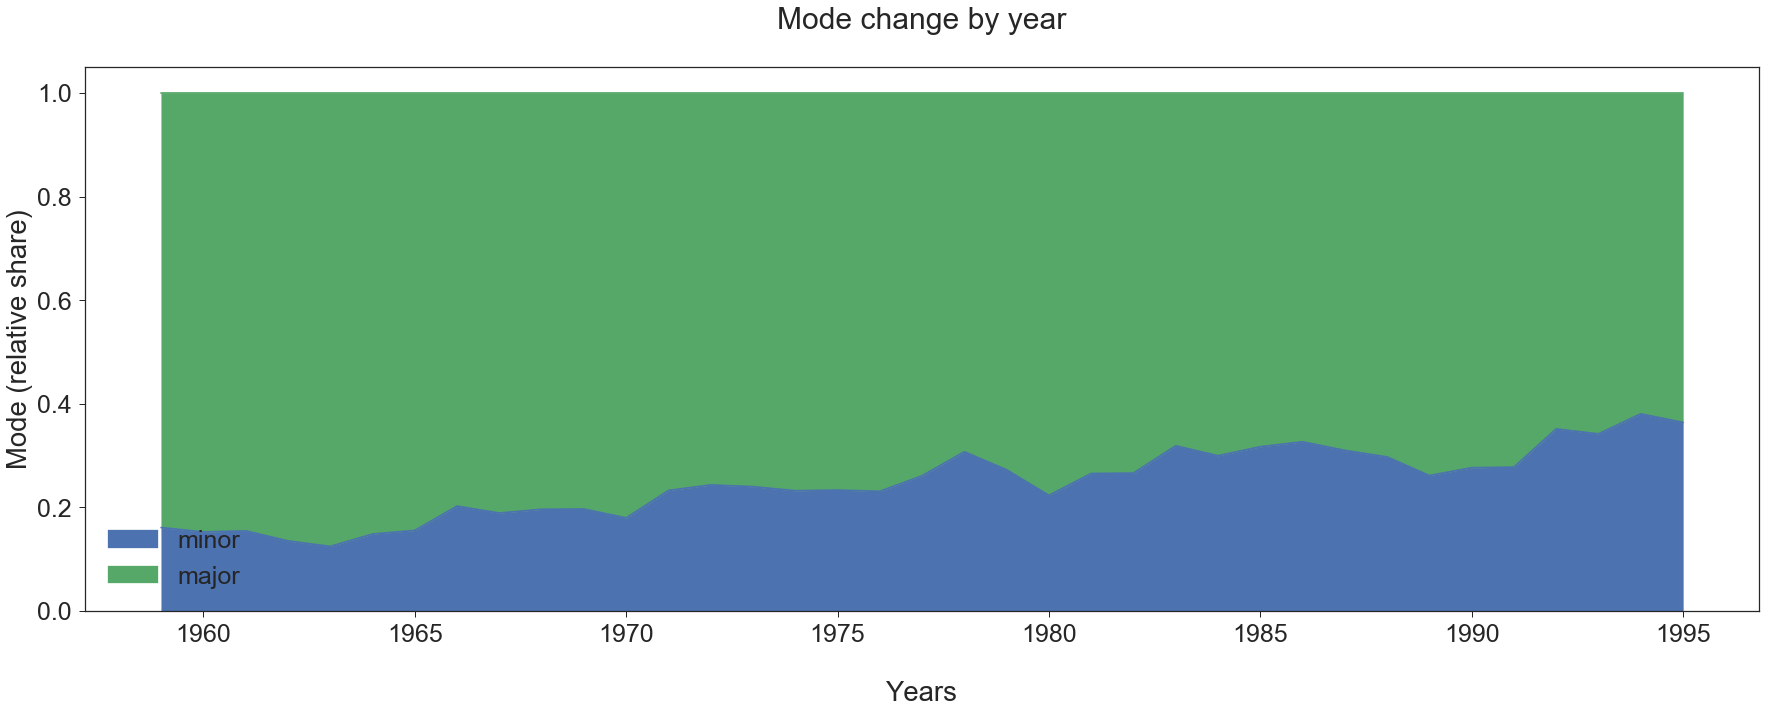

In [102]:
ax = plot_discrete_feature_evolution(yearly_features, 'mode', granularity = 'Years', categories = ['minor', 'major']);
ax.legend(loc=3)

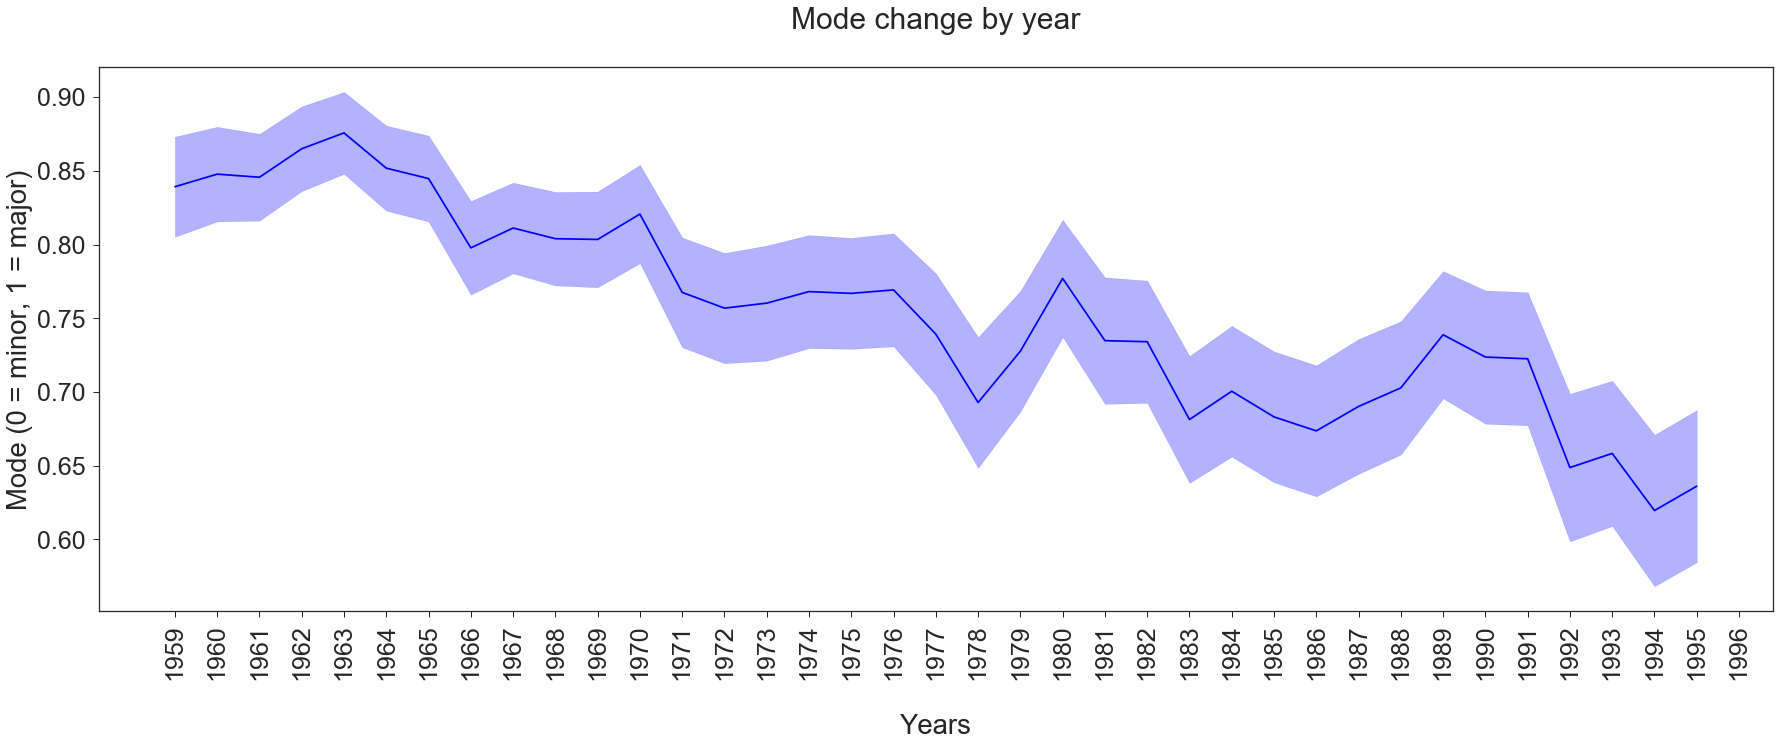

In [70]:
plot_feature_evolution(yearly_features, 'mode', N = 1, granularity = 'Years', unit = '(0 = minor, 1 = major)');

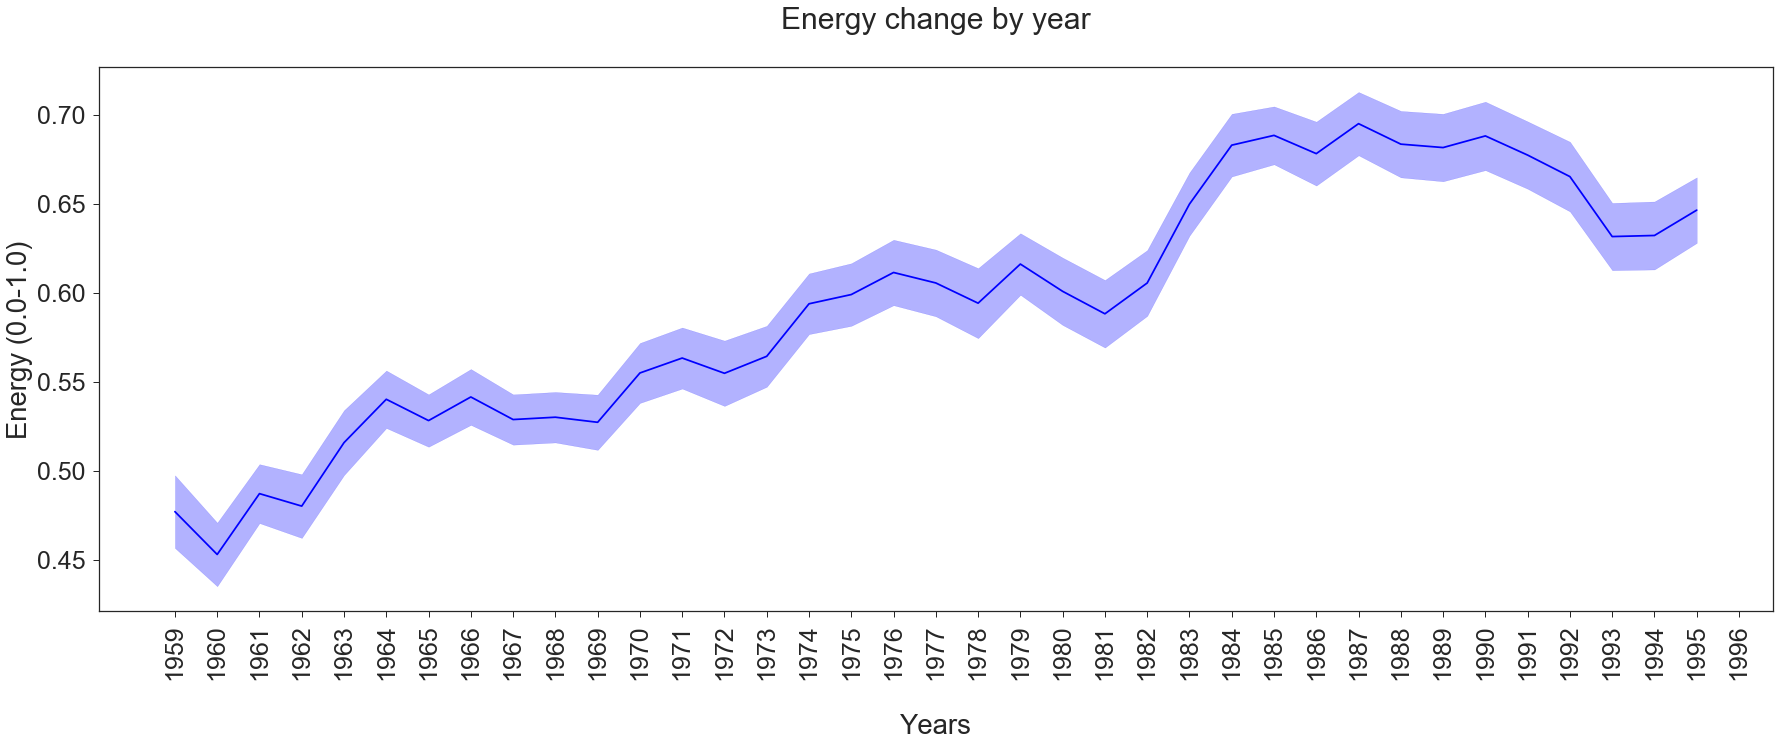

In [71]:
plot_feature_evolution(yearly_features, 'energy', N = 1, granularity = 'Years', unit = '(0.0-1.0)');

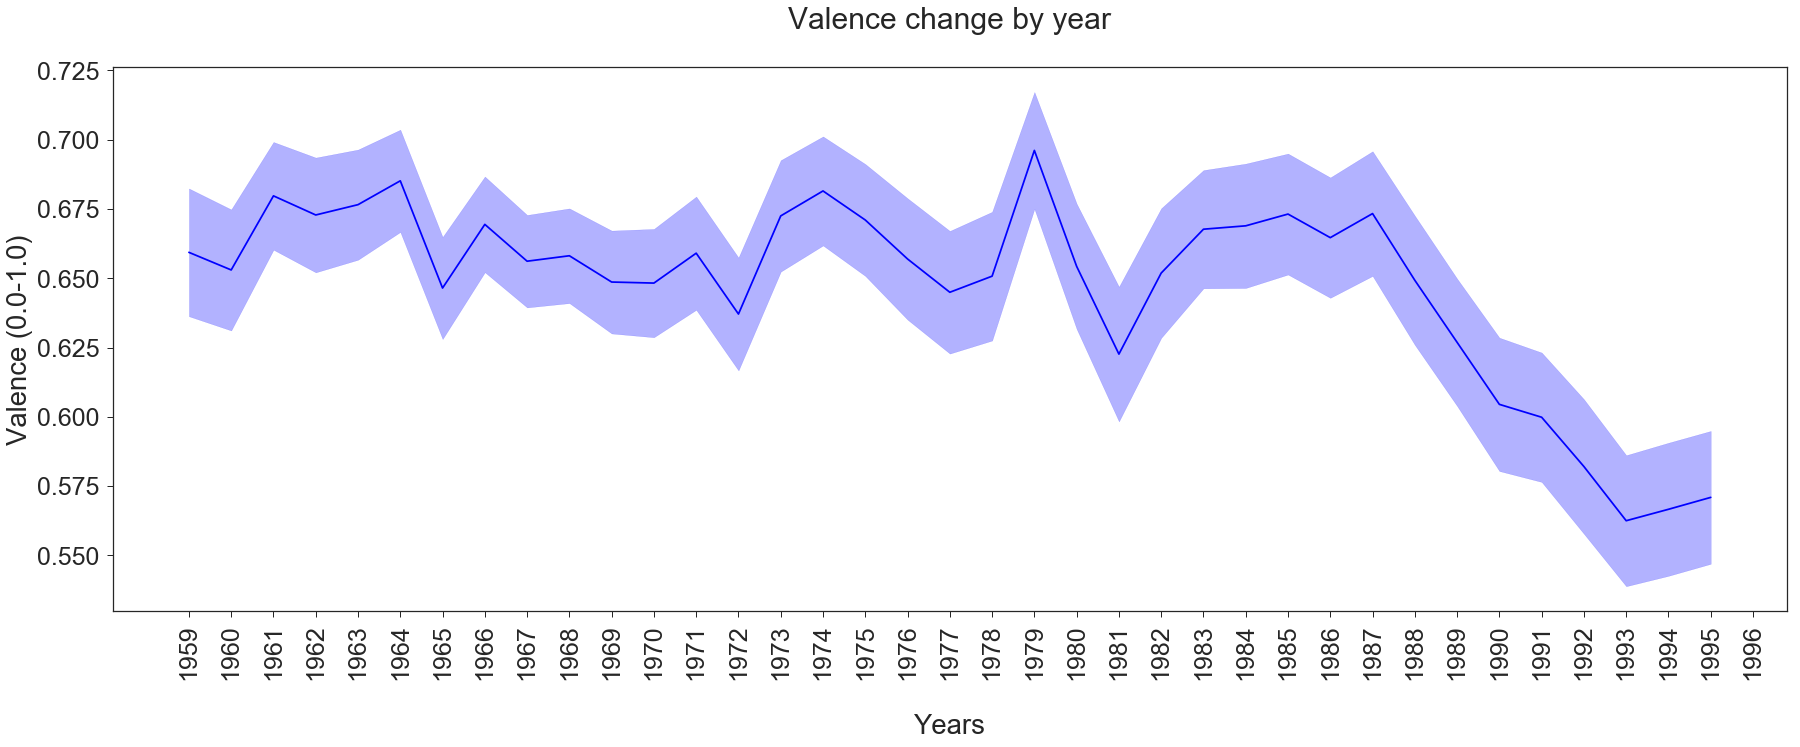

In [72]:
plot_feature_evolution(yearly_features, 'valence', N = 1, granularity = 'Years', unit = '(0.0-1.0)');

# Degree salience

In [73]:
functions = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

smoothed = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

In [74]:
years = np.arange(1959, 1996)

In [75]:
keys = functions.keys()

In [76]:
first, last = {}, {}

for key in keys:
    first[key] = yearly_features[key][0]
    last[key] = yearly_features[key][36]

In [77]:
for key in keys:
    for i in range(2):
        functions[key].append(first[key])
    for i in range(len(years)):
        functions[key].append(yearly_features[key][i])
    for i in range(2):
        functions[key].append(last[key])

In [78]:
for key in keys:
    for i in range(len(years)):
        values = []
        for j in range(i, i+5):
            for element in functions[key][j]:
                values.append(element)
        smoothed[key].append(values)

In [79]:
low_bound = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

high_bound = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

In [80]:
for key in keys:
    for i in range(len(years)):
        m, lb, ub = mean_confidence_interval(smoothed[key][i], confidence=0.95)
        low_bound[key].append(lb)
        high_bound[key].append(ub)

In [103]:
def degree_salient_drift(features, feature, low_bound, high_bound, N = 48, granularity = 'Months'):    
    
    color = '#989898'
    lower_bound, mean, upper_bound = compute_bounds(features, feature)
    salient_low, salient_high = [], []
    ampl_low, ampl_high = [], []
    
    for i in range(len(lower_bound)):
        if lower_bound[i] > high_bound[feature][i//N]:
            salient_high.append(i)
            ampl_high.append(mean[i])
            
        if upper_bound[i] < low_bound[feature][i//N]:
            salient_low.append(i)
            ampl_low.append(mean[i])

    sns.set(rc={'figure.figsize':(30,10)})
    sns.set_style("ticks")
    sns.set_context('notebook', font_scale=2.5)
    
    years = np.arange(1959, 1997)
    #plt.fill_between(range(len(mean)), upper_bound, lower_bound, color = color, alpha = .3)
    plt.plot(mean, color)
    plt.plot(salient_low, ampl_low, color='#01B9FF', marker='o', linestyle = '')
    plt.plot(salient_high, ampl_high, color='#FF0101', marker='o', linestyle = '')
    
    name = feature.replace('_', ' ').capitalize()
    if feature == 'duration_ms':
        name = 'Duration'
    plt.xticks(np.arange(0, (len(years))*N, N), years, rotation = 'vertical')
    plt.xlabel('\n Years')
    plt.ylabel(name)
    plt.title(name + ' salient peaks by ' + granularity.lower()[:-1] + ' \n')

    return plt, salient_low, salient_high

In [104]:
salient_low_list = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}
salient_high_list = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

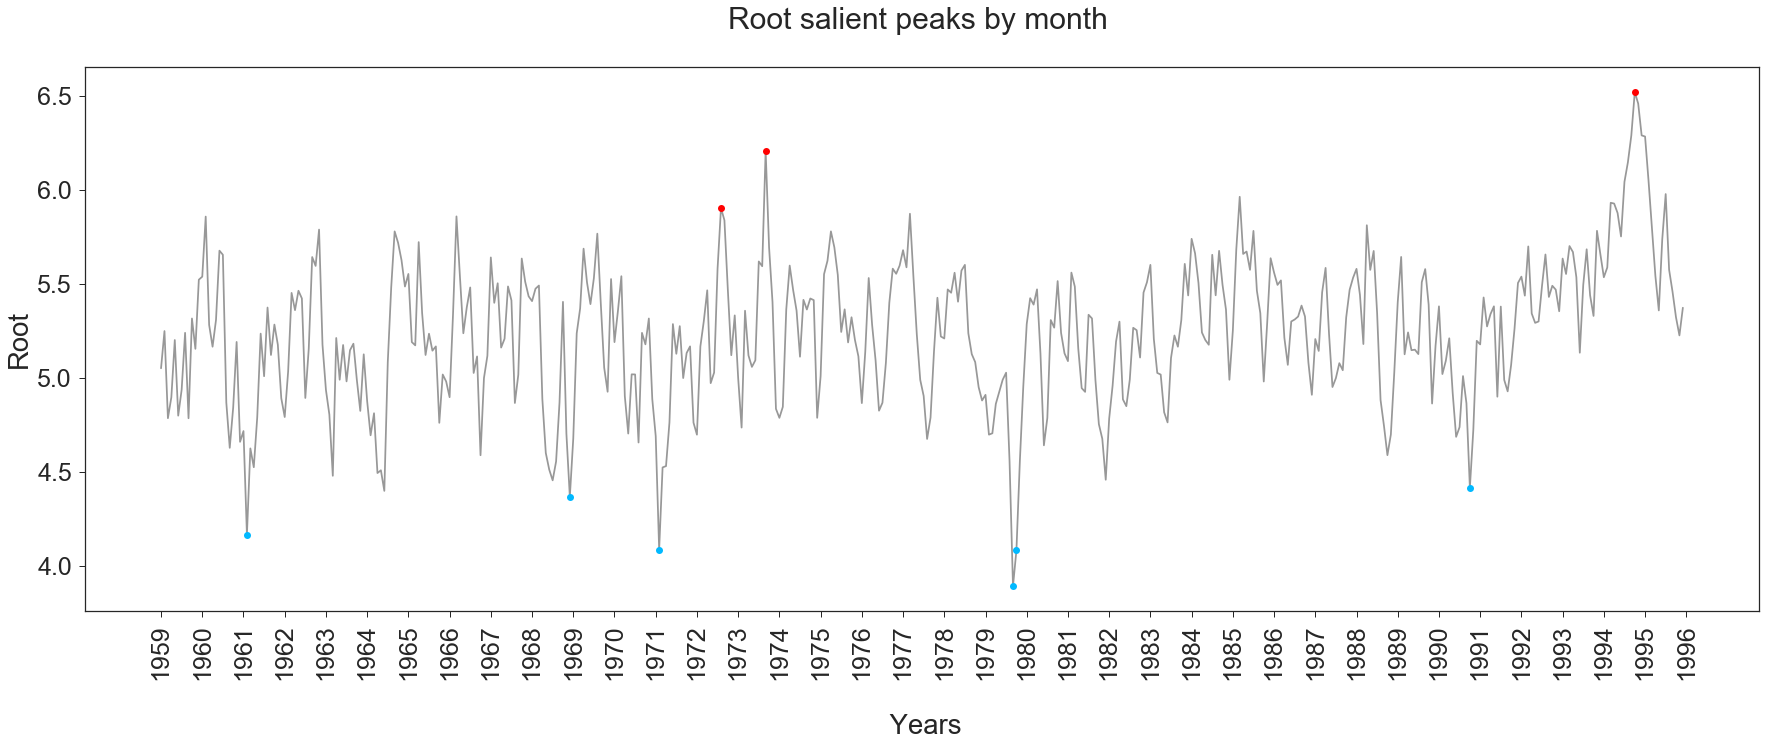

In [105]:
feature = 'root'
plt, salient_low_list[feature], salient_high_list[feature] = degree_salient_drift(
    monthly_features, feature, low_bound, high_bound, N = 12)
plt.show;

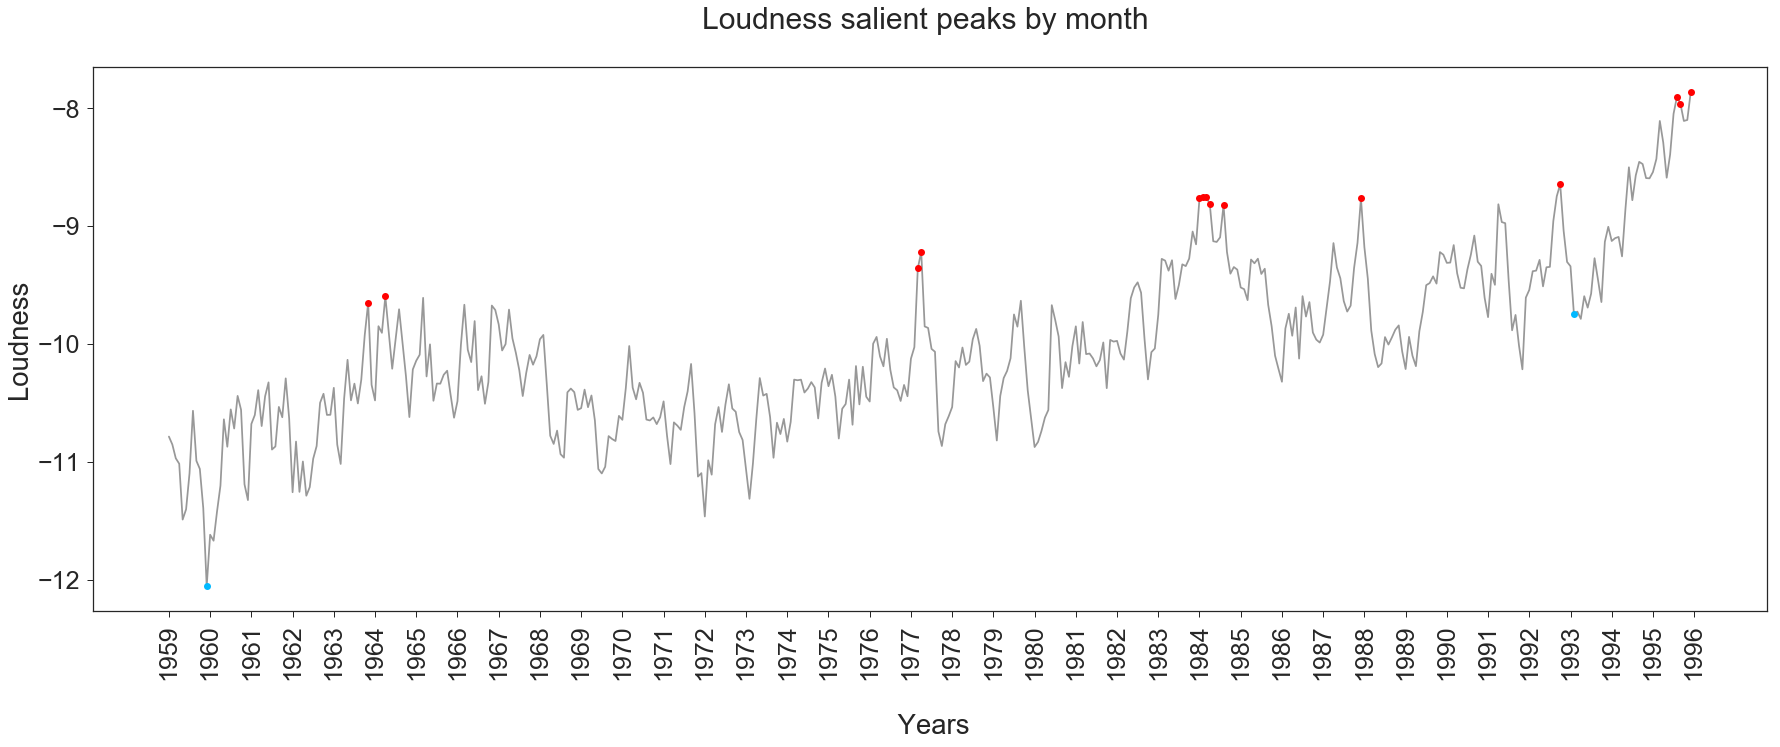

In [106]:
feature = 'loudness'
plt, salient_low_list[feature], salient_high_list[feature] = degree_salient_drift(
    monthly_features, feature, low_bound, high_bound, N = 12)
plt.show;

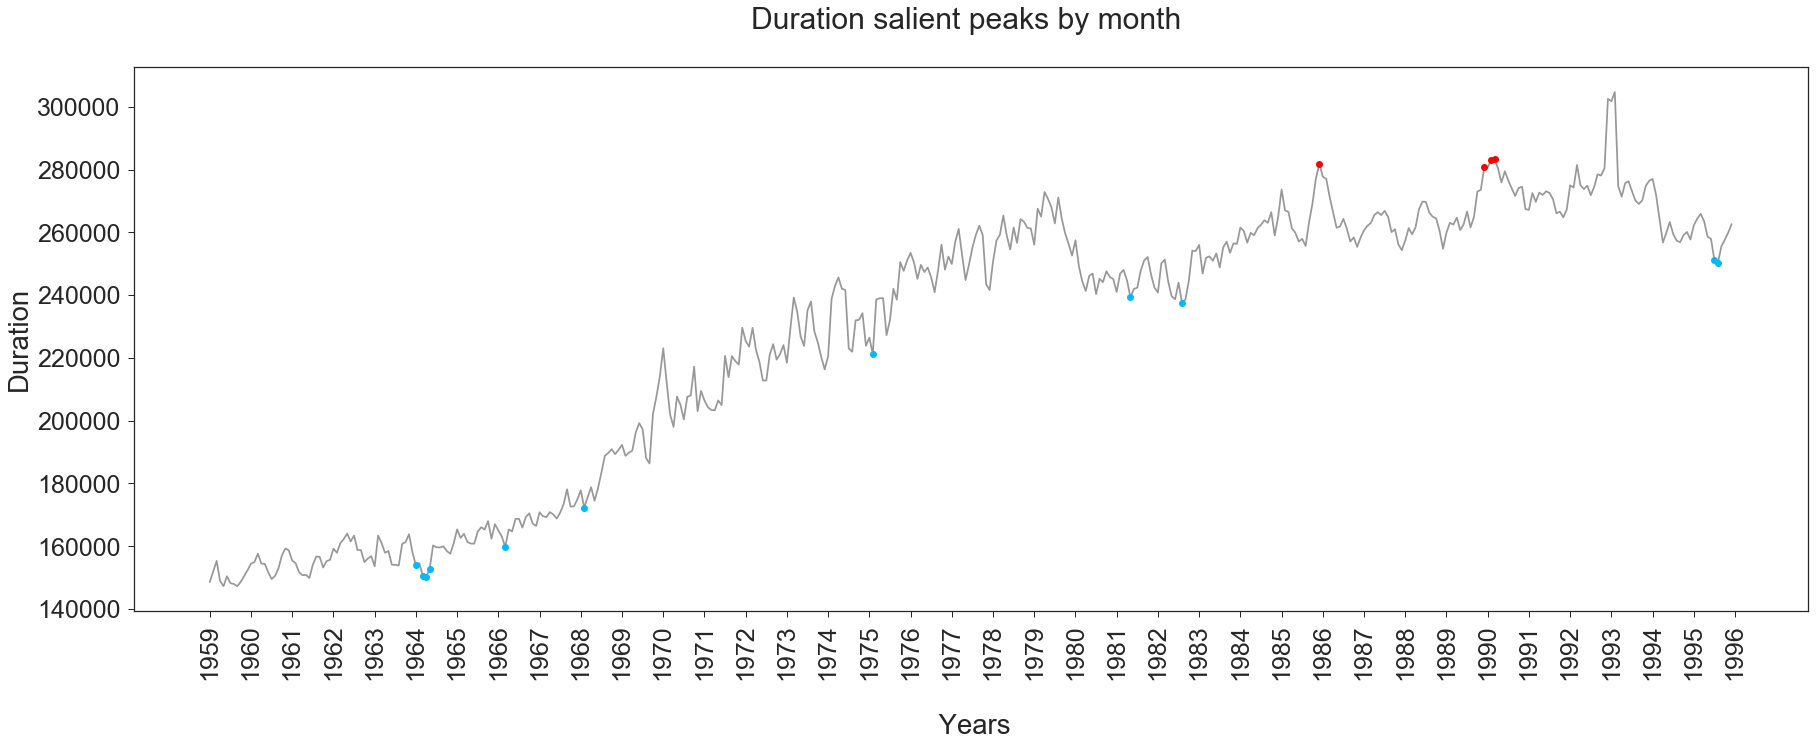

In [107]:
feature = 'duration_ms'
plt, salient_low_list[feature], salient_high_list[feature] = degree_salient_drift(
    monthly_features, feature, low_bound, high_bound, N = 12)
plt.show;

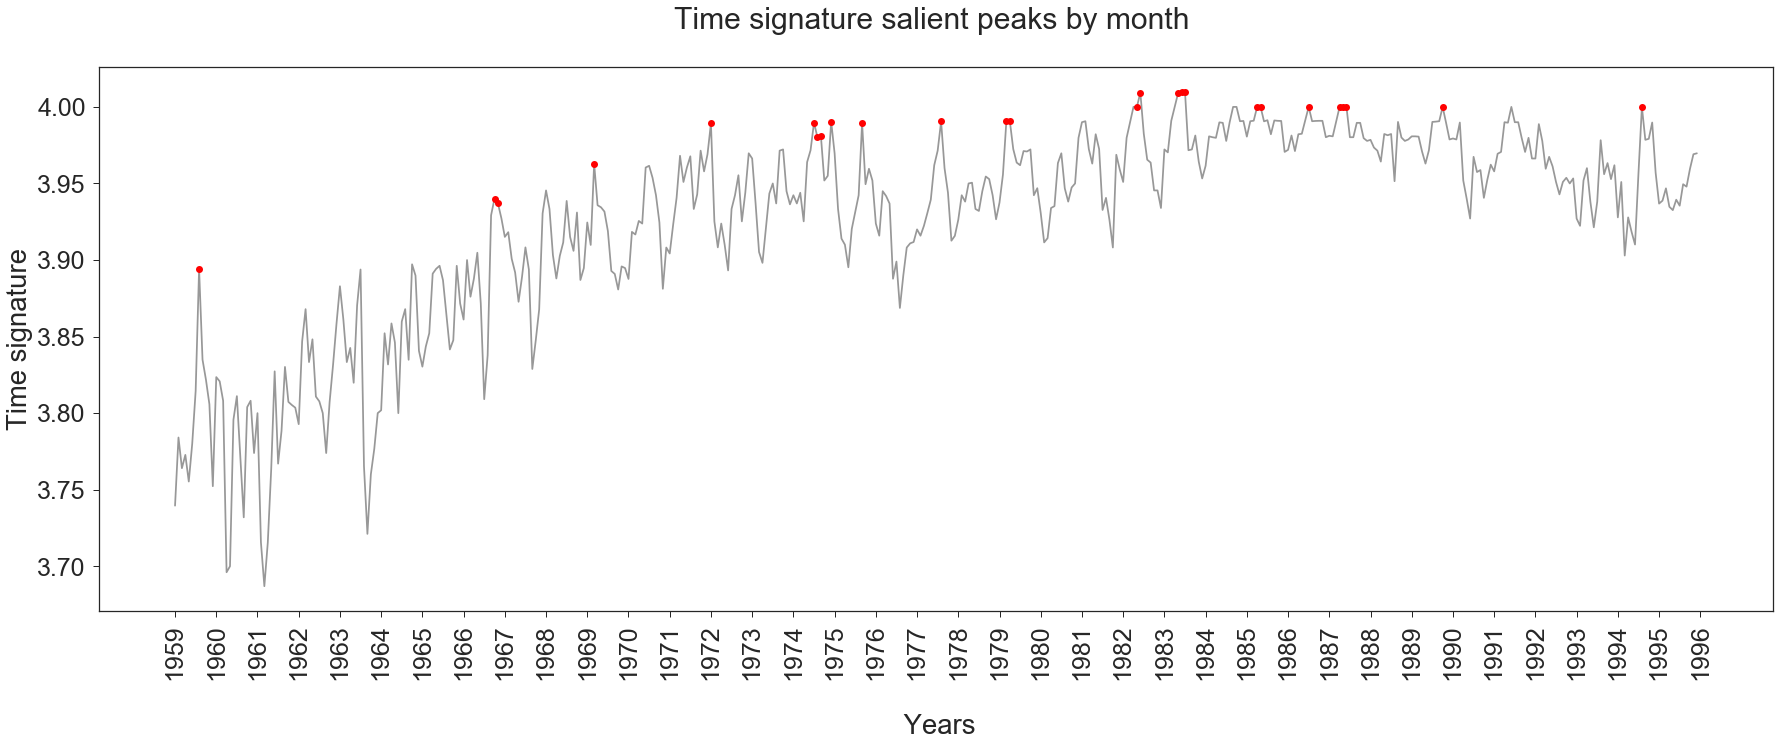

In [108]:
feature = 'time_signature'
plt, salient_low_list[feature], salient_high_list[feature] = degree_salient_drift(
    monthly_features, feature, low_bound, high_bound, N = 12)
plt.show;

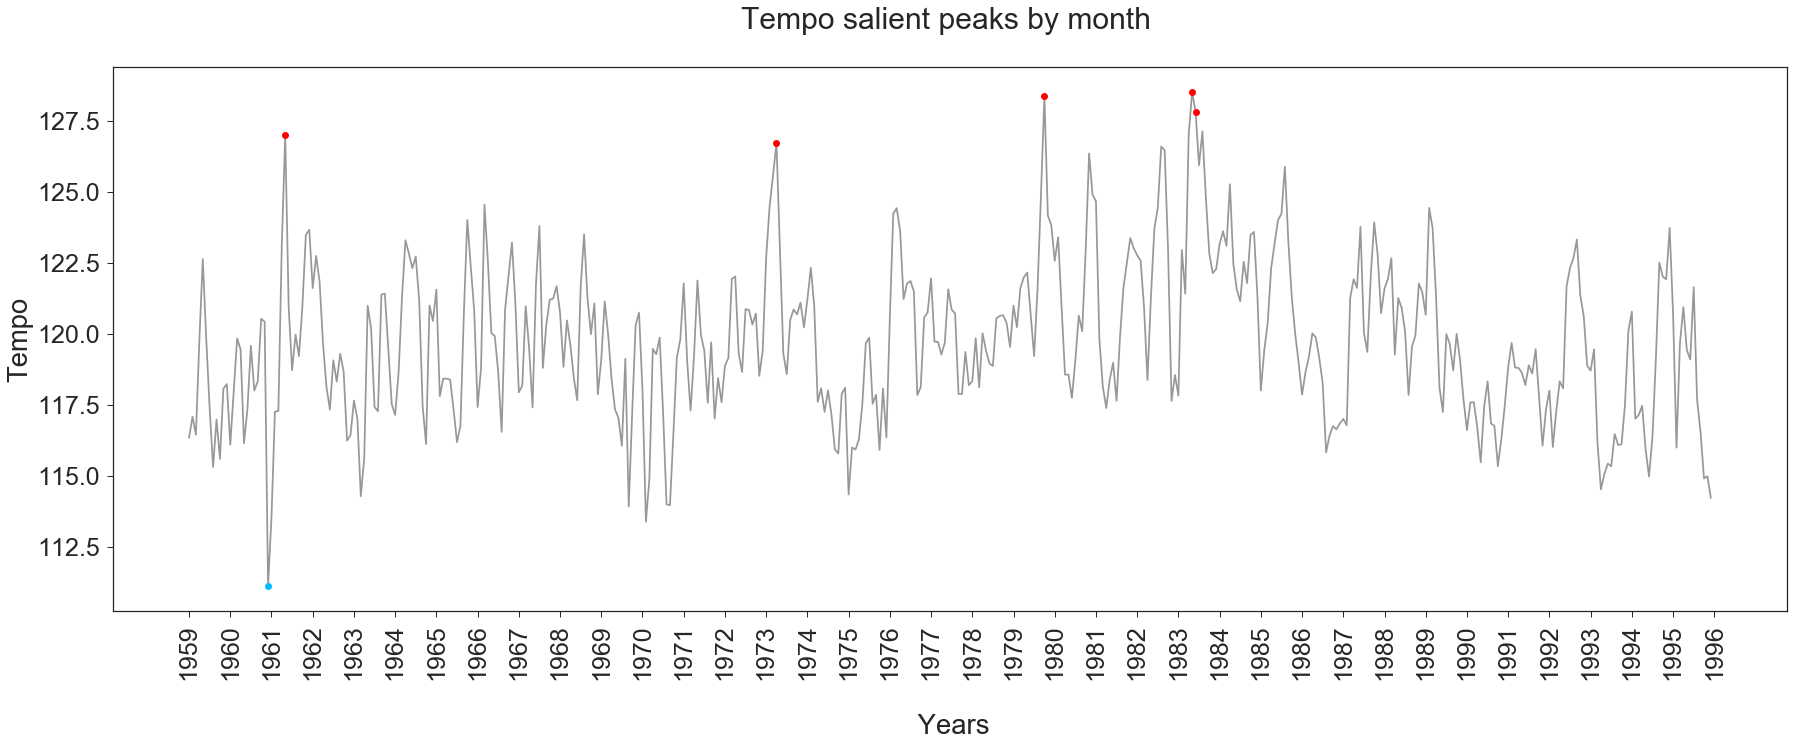

In [109]:
feature = 'tempo'
plt, salient_low_list[feature], salient_high_list[feature] = degree_salient_drift(
    monthly_features, feature, low_bound, high_bound, N = 12)
plt.show;

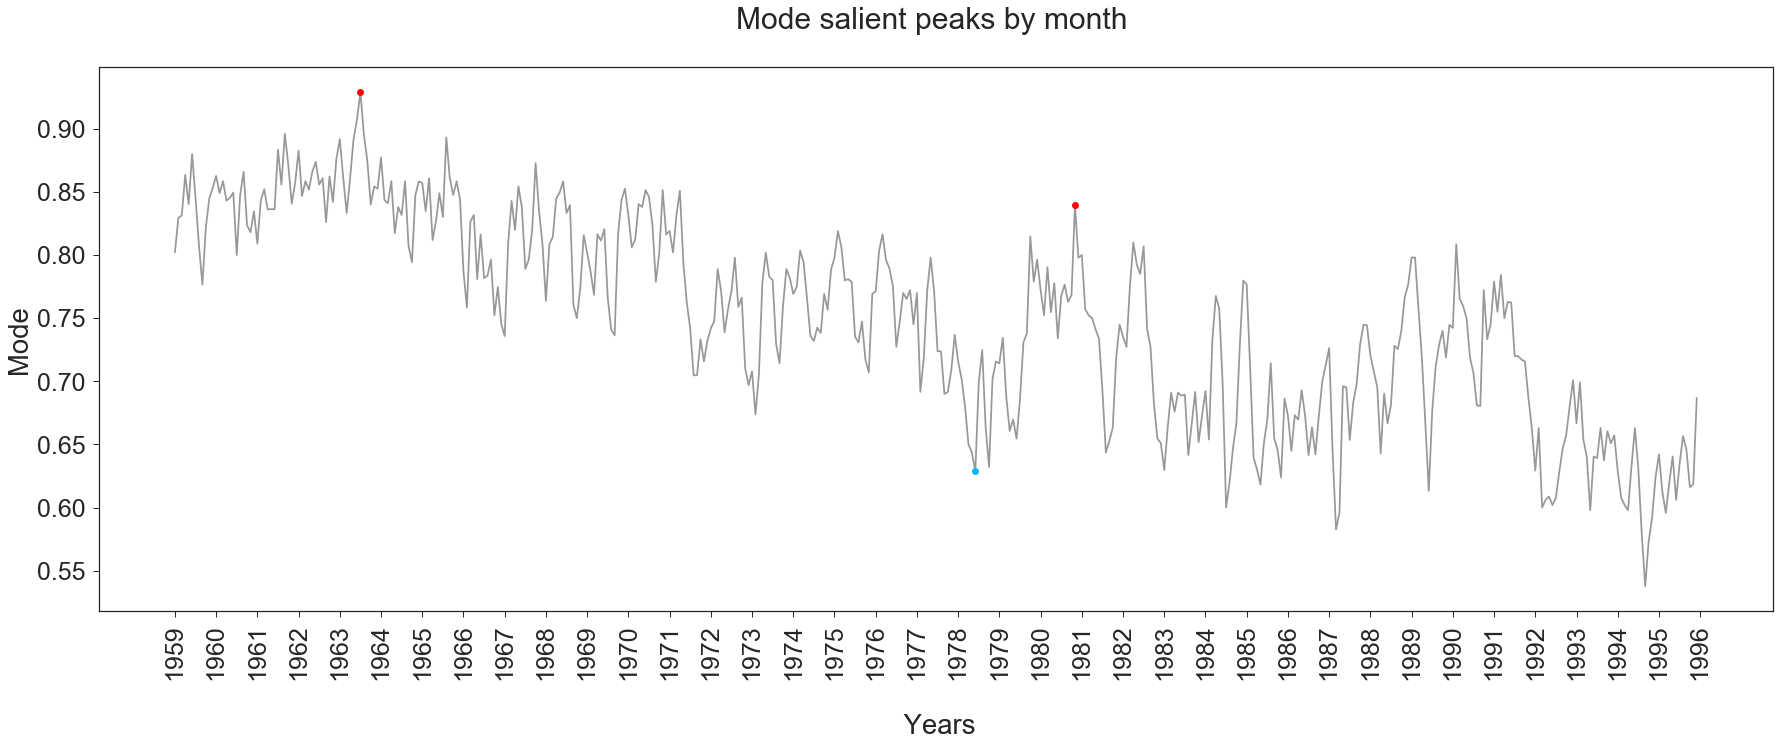

In [110]:
feature = 'mode'
plt, salient_low_list[feature], salient_high_list[feature] = degree_salient_drift(
    monthly_features, feature, low_bound, high_bound, N = 12)
plt.show;

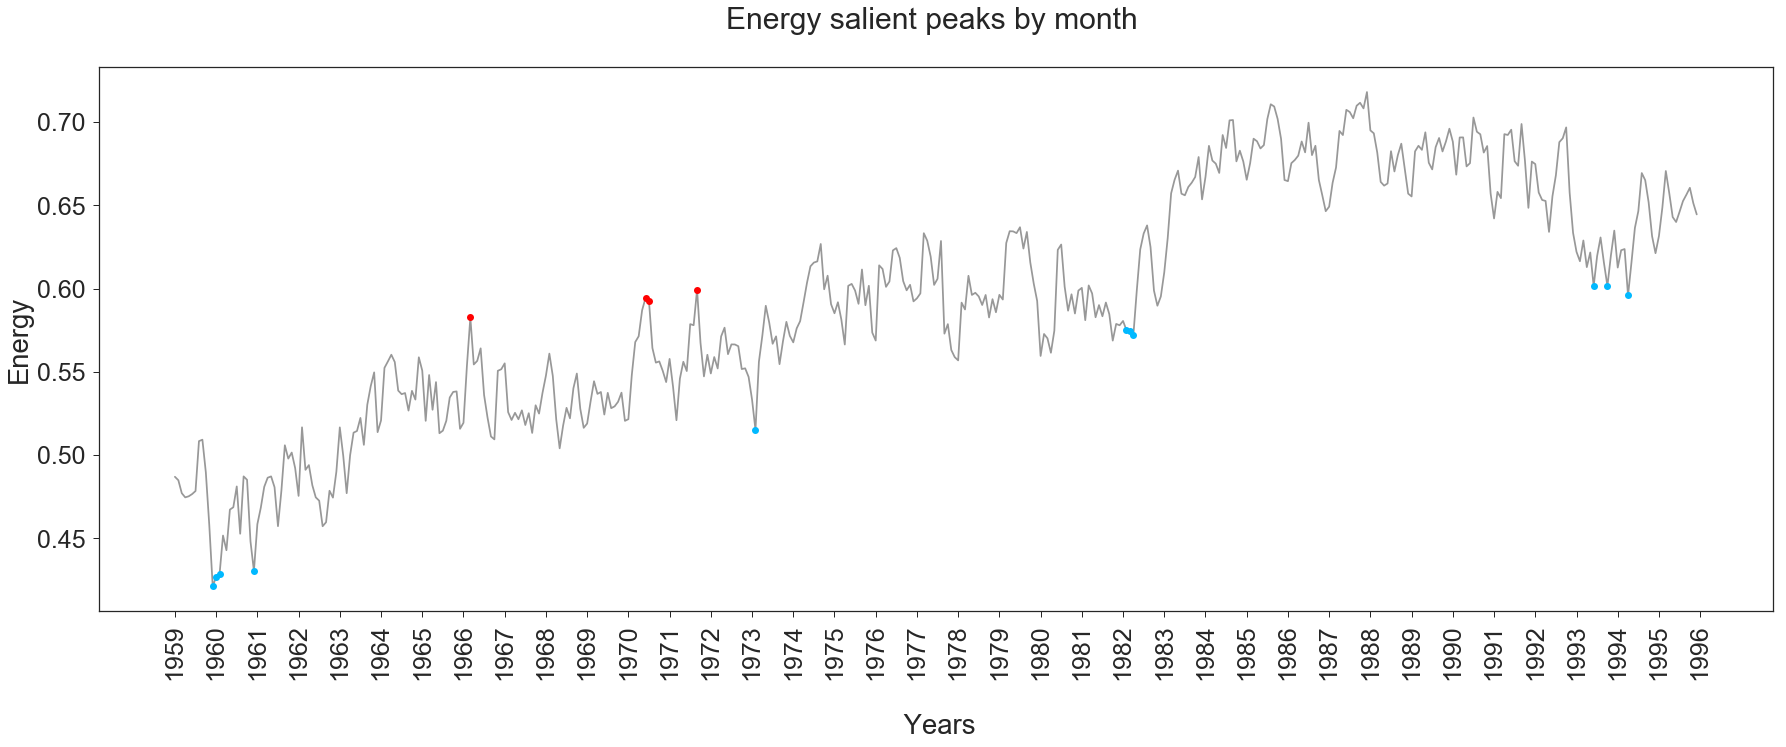

In [111]:
feature = 'energy'
plt, salient_low_list[feature], salient_high_list[feature] = degree_salient_drift(
    monthly_features, feature, low_bound, high_bound, N = 12)
plt.show;

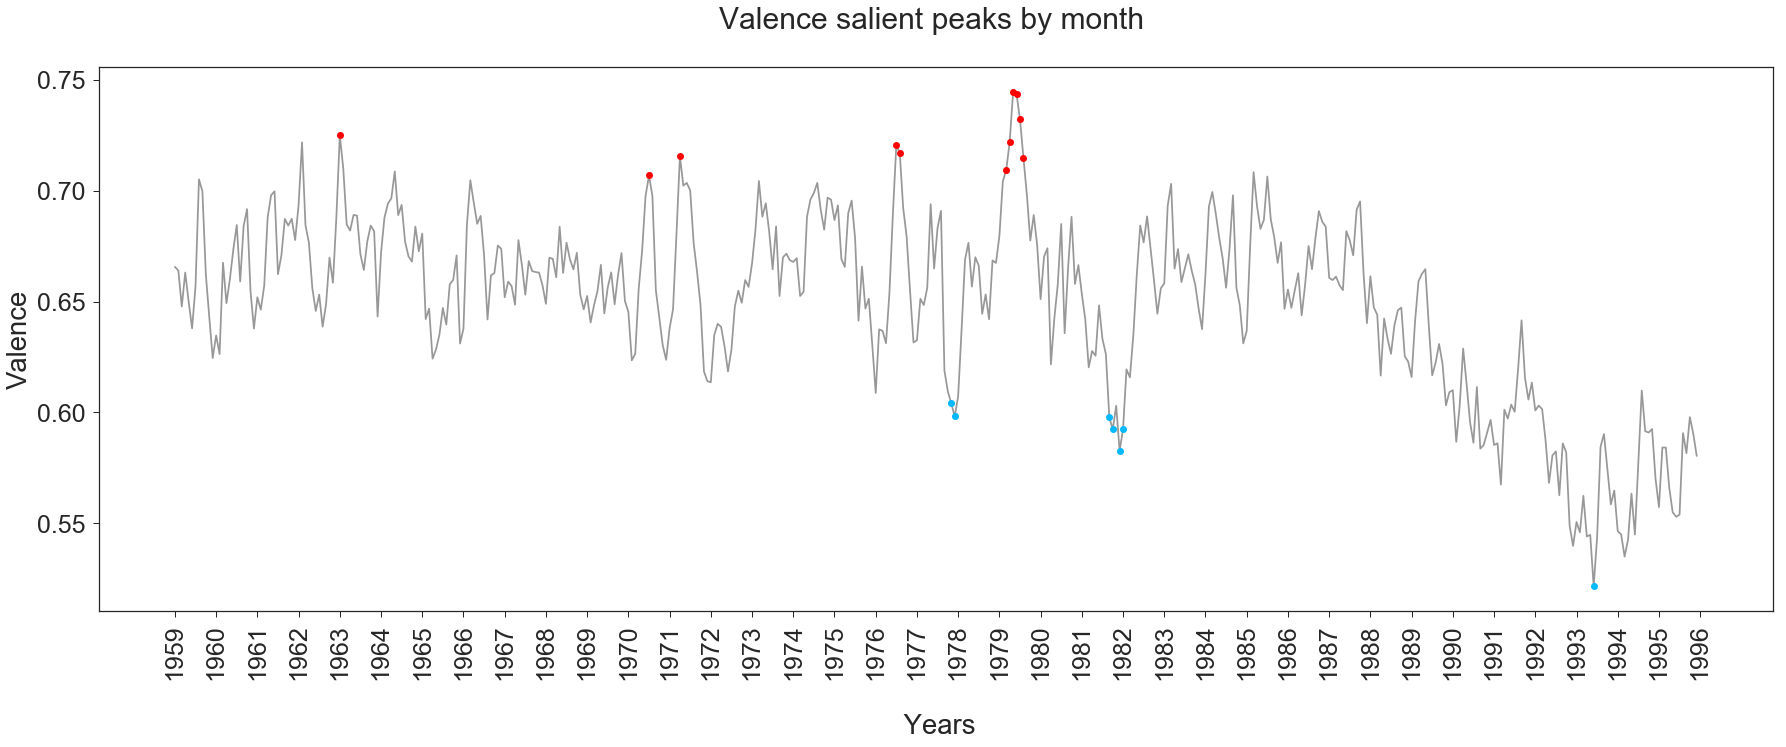

In [112]:
feature = 'valence'
plt, salient_low_list[feature], salient_high_list[feature] = degree_salient_drift(
    monthly_features, feature, low_bound, high_bound, N = 12)
plt.show;

In [91]:
salient_low_list

{'root': [25, 119, 145, 248, 249, 381],
 'loudness': [11, 409],
 'duration_ms': [60, 62, 63, 64, 86, 109, 193, 268, 283, 438, 439],
 'time_signature': [],
 'tempo': [23],
 'mode': [233],
 'energy': [11, 12, 13, 23, 169, 277, 278, 279, 413, 417, 423],
 'valence': [226, 227, 272, 273, 275, 276, 413]}

In [92]:
salient_high_list

{'root': [163, 176, 429],
 'loudness': [58,
  63,
  218,
  219,
  300,
  301,
  302,
  303,
  307,
  347,
  405,
  439,
  440,
  443],
 'duration_ms': [323, 371, 373, 374],
 'time_signature': [7,
  93,
  94,
  122,
  156,
  186,
  187,
  188,
  191,
  200,
  223,
  242,
  243,
  280,
  281,
  292,
  293,
  294,
  315,
  316,
  330,
  339,
  340,
  341,
  369,
  427],
 'tempo': [28, 171, 249, 292, 293],
 'mode': [54, 262],
 'energy': [86, 137, 138, 152],
 'valence': [48, 138, 147, 210, 211, 242, 243, 244, 245, 246, 247]}

In [93]:
drifts = []

for key in salient_low_list.keys():
    for drift in salient_low_list[key]:
        drifts.append(drift)
        
for key in salient_high_list.keys():
    for drift in salient_high_list[key]:
        drifts.append(drift)

In [94]:
count = pd.Series(np.zeros(444), np.arange(0, 444))
drifts_count = pd.Series(drifts).value_counts().sort_index()
drifts_count = pd.concat([drifts_count, count])
drifts_count = pd.DataFrame(drifts_count)
drifts_count['duplicates'] = drifts_count.index
drifts_count = drifts_count.drop_duplicates(subset = 'duplicates', keep = 'first').drop(
    columns = 'duplicates').rename(columns = {0:'Drifts'}).sort_index()

Text(0.5,0,'Months (numbered from 1/1959 to 12/1995)')

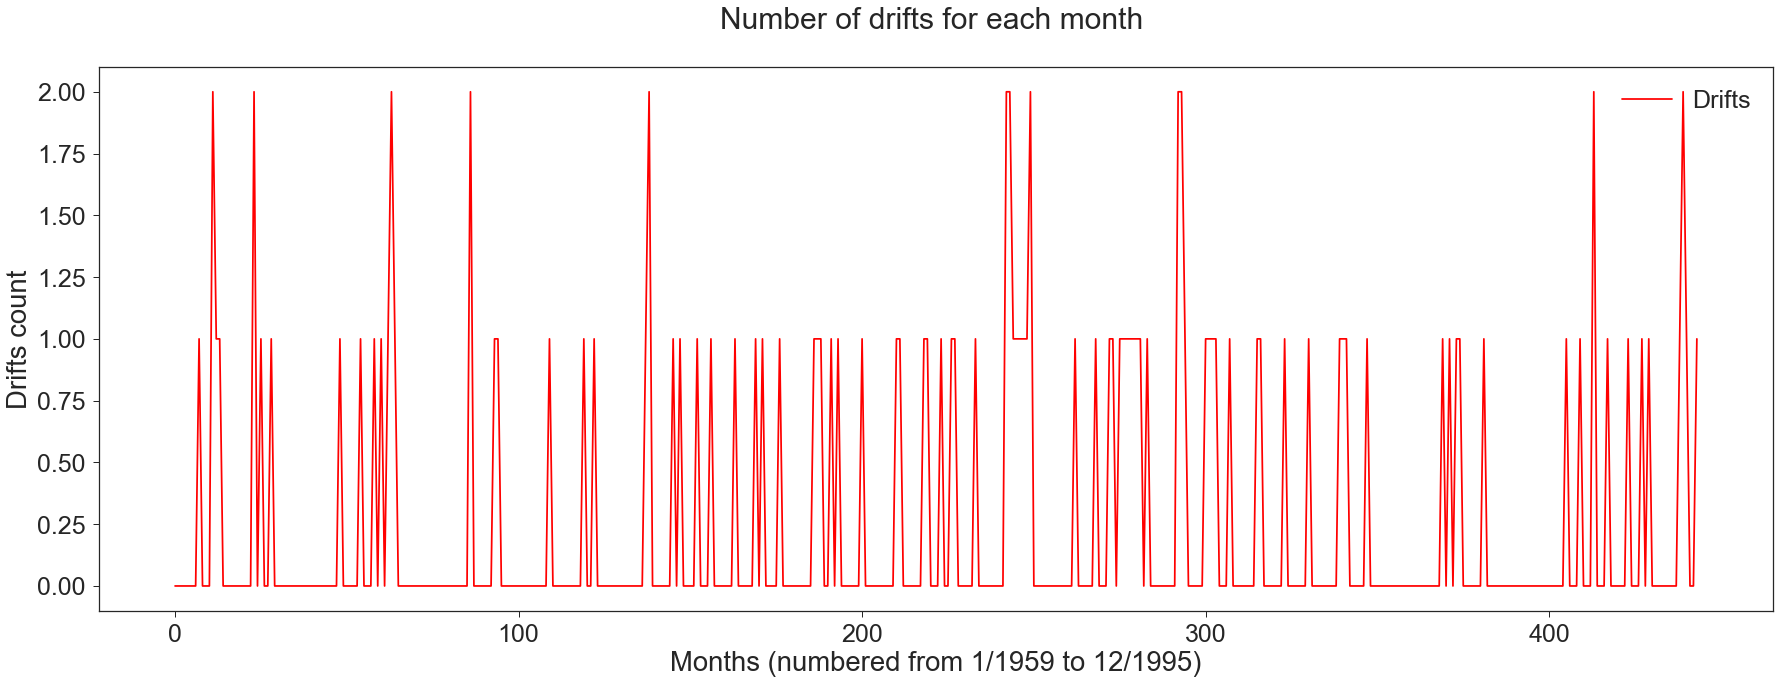

In [95]:
ax = drifts_count.plot(color = 'red', title = 'Number of drifts for each month \n')
ax.set_ylabel('Drifts count')
ax.set_xlabel('Months (numbered from 1/1959 to 12/1995)')

In [96]:
months_serie = pd.Series(months)

In [97]:
salient_low_list['valence']

[226, 227, 272, 273, 275, 276, 413]

In [98]:
months_serie[salient_low_list['duration_ms']]

60     1964-01
62     1964-03
63     1964-04
64     1964-05
86     1966-03
109    1968-02
193    1975-02
268    1981-05
283    1982-08
438    1995-07
439    1995-08
dtype: object

In [99]:
months_serie[salient_high_list['duration_ms']]

323    1985-12
371    1989-12
373    1990-02
374    1990-03
dtype: object

In [100]:
drifts_count[drifts_count != 0.].dropna()

Drifts
7       1.0
11      2.0
12      1.0
13      1.0
23      2.0
25      1.0
28      1.0
48      1.0
54      1.0
58      1.0
60      1.0
62      1.0
63      2.0
64      1.0
86      2.0
93      1.0
94      1.0
109     1.0
119     1.0
122     1.0
137     1.0
138     2.0
145     1.0
147     1.0
152     1.0
156     1.0
163     1.0
169     1.0
171     1.0
176     1.0
..      ...
294     1.0
300     1.0
301     1.0
302     1.0
303     1.0
307     1.0
315     1.0
316     1.0
323     1.0
330     1.0
339     1.0
340     1.0
341     1.0
347     1.0
369     1.0
371     1.0
373     1.0
374     1.0
381     1.0
405     1.0
409     1.0
413     2.0
417     1.0
423     1.0
427     1.0
429     1.0
438     1.0
439     2.0
440     1.0
443     1.0

[96 rows x 1 columns]

In [101]:
file_salient_high = open('json/salient_high.json', 'w')
file_salient_low = open('json/salient_high.json', 'w')

json.dump(salient_high_list, file_salient_high)
json.dump(salient_low_list, file_salient_low)